In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
import os
from model_utils import *
#from iri2016 import timeprofile, timeprofile2

In [2]:
def getF107(month,year):
    dir_path = "geomagnetic_indices"
    filename = "hourly-geomagnetic-indices-%02d-%d.txt" % (month, year)
    filename = './' + dir_path + '/' + filename
    #current_month = 'Noviembre-2020'
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    current_month = '%s-%d' % (meses[month-1], year)
    dir_plots = 'Plots-%s/' % current_month
    Data = pd.read_csv(filename,delimiter=r"\s+")#
    indices = GetIndices(Data)
    Data.set_index(indices)
    
    return Data

In [3]:
def getIndexF107(year, doy, hour):
    #month=12
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    month = d.month
    F107 = getF107(month,year)
    #F107.tail()
    a = F107.loc[(F107['Hour'] == hour) & (F107['DayOfYear'] == doy), 'F107']
    return float(a)

In [10]:
PlotFlag=True
year = 2021
month = 2
str_month = GetMonth(month)
day = 1
current_month = '%s-%d' % (str_month, year)
directory = 'Data-%s/' % current_month
directory_eclipse = 'Data-%s/' % current_month
plot_format = 'png'
filename1 ='jul%d%02d%02d_150km.001.hdf5' % (year,month,day)
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15
list_avg = []
list_std = []
print(current_month)

Febrero-2021


In [88]:
def GetStandardDriftMatrix(directory,filename, plot_format):
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    alturas = hf['Data/Table Layout/']['gdalt']
    range_file = np.array(hf['Data/Array Layout/']['range'])
    timestamps = hf['Data/Array Layout/']['timestamps']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    #rango2D = np.array(hf['Data/Array Layout/2D Parameters/range'])
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)

    alturas = np.array(getattr(alturas, "tolist", lambda: alturas)())
    rango = alturas
    ###########################################################
    ## Arreglos del archivo:
    ran_max = np.max(rango)
    ran_min = np.min(rango)
    range_diff = np.diff(rango)
    delta_range = range_diff[0]
    ranNum = int((ran_max-ran_min)/delta_range) + 1
    range_file = np.arange(ran_min,ran_max+delta_range,delta_range)#np.linspace(ran_min, ran_max, ranNum)
    #delta_range = range_diff[0] #valor constante para todo el arreglo
    print("ran_max: ", ran_max)
    
    datetime_objects = []
    for ts in timestamps:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects)
    delta_time_array = np.diff(index)[0]/ np.timedelta64(1, 's')#(dtf-dt0).total_seconds()/ntimes#/np.timedelta64(1, 's')#np.linspace(dt0,dtf,timedelta(seconds=300))
    dt = index[1]-index[0]
    ###Creando arreglo de datetime objetcs:
    strf = '%d-%02d-%02d 07:00:00' % (index[0].year, index[0].month, index[0].day)
    str0 = '%d-%02d-%02d 17:00:00' % (index[0].year, index[0].month, index[0].day)
    dt0 = datetime.datetime.strptime(str0, '%Y-%m-%d %H:%M:%S')
    dtf = datetime.datetime.strptime(strf, '%Y-%m-%d %H:%M:%S')
    ntimes = 569#288
    ncols = 33#100#64#96#100
    dt_list = []
    dt_array = np.arange(dt0,dtf+dt,dt)#np.array(dt_list)
    print("delta_time_array: ", delta_time_array)
    ###################################################################
    ## Arreglos Estandarizados##########################
    MinRange, MaxRange = 130.95,178.95#945#1425#1485#945.0#1425.0#ran_min, ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/(delta_range)) + 1 #
    DataMatrix = np.ones((DataMatrixRows, ntimes))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.arange(MinRange,MaxRange+delta_range,delta_range)
    ###################################################################
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    mes = date_time_obj.month
    month_prime = mes
    mes = GetMonth(month_prime)
    dia = date_time_obj.day
    anio = date_time_obj.year

    dir_plots = '.'#'Plots-150km-%s-%d' % (mes, anio)
    #print("Shapes zonal, range 2D: ", v_zonal.T.shape, rango2D.shape)
    print("Shapes vertical, range_array, and datetime_objs: ", v_vertical.T.shape, range_file.shape, len(datetime_objects))
    print("Shapes standard: ", DataMatrix.shape, range_array.shape, dt_array.shape)
    #######################################################################################################
    print(range_array[-1])
    print(range_file[-1])
    #print(rango2D[-1])
    #print(rango[-1])
    #diff = list(np.diff(rango2D).flatten())
    #print(diff.count(14), diff.count(15), len(diff))
    
    datetime_objects = np.array(datetime_objects)
    RowInMatrixTime = np.array((datetime_objects-dt0)/timedelta(seconds=delta_time_array),dtype=int)
    DataMat = np.ones((ntimes,ncols))*np.nan
    col = 0 #counter for current columns
    for i in range(0,datetime_objects.shape[0]):
        row = RowInMatrixTime[i]
        DataMat[row,:] = v_vertical[i,:]
    
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
    #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        clrs= ax.pcolormesh(mdates.date2num(dt_array), range_array, DataMat.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Derivas Verticales ISR (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (anio, month_prime, dia)
        #ax.set_ylim(300, 1200)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.set_label(r'Derivas verticales (m/s)')
        plt.savefig(r'%s/Ecos-de-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)   
    ###############################: ", DataMatrix.shape, range_file.shape, dt_array.shape)
    ####################################################################
    
    
    return DataMat.T, range_array, dt_array

In [89]:
file_hf5 = directory_eclipse + filename1
hf = h5py.File(file_hf5, 'r')

with h5py.File(file_hf5, 'r') as f:
    g = f.visit(print)

Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/1D Parameters/Data Parameters
Data/Array Layout/1D Parameters/gdlatr
Data/Array Layout/1D Parameters/gdlonr
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dvipe1
Data/Array Layout/2D Parameters/dvipn1
Data/Array Layout/2D Parameters/gdalt
Data/Array Layout/2D Parameters/snl
Data/Array Layout/2D Parameters/vipe1
Data/Array Layout/2D Parameters/vipn1
Data/Array Layout/Layout Description
Data/Array Layout/range
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters


In [90]:
datetime_str = '2021-02-01 13:55:26'
datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')



In [91]:
DataMat, range_array, dt_array = GetStandardDriftMatrix(directory,filename1, plot_format)

ran_max:  168.45
delta_time_array:  2760.0
Shapes vertical, range_array, and datetime_objs:  (26, 502) (26,) 502
Shapes standard:  (33, 569) (33,) (0,)
178.95
168.45


ValueError: could not broadcast input array from shape (26) into shape (33)

In [10]:
#print(timestamps[0])
str_t0 = '2021-%02d-%02d 09:00:00' % (day_index[0].month, day_index[0].day)
str_tf = '2021-%02d-%02d 17:00:00' % (day_index[0].month, day_index[0].day)

t0 = datetime.datetime.strptime(str_t0, '%Y-%m-%d %H:%M:%S')
tf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
i = 0
ind0 = 0
indf = -1
datetime_objects = [] 
for ts in timestamps:
    #datetime_objects.append(datetime.timestamp(ts))
    dt = datetime.datetime.fromtimestamp(ts)
    datetime_objects.append(dt)
    if (dt >= t0):
        #print('9 AM!', i)
        ind0=i
        continue
    if (dt >= tf):
        #print('5 PM!')
        indf=i
    i = i + 1
    
    #if indf == 0:
    #    inf
print("índices iniciales y finales:", ind0, indf)
print(datetime_objects[-1])
print(datetime_objects[ind0])

índices iniciales y finales: 53 -1
2021-02-01 16:28:13
2021-02-01 09:00:28


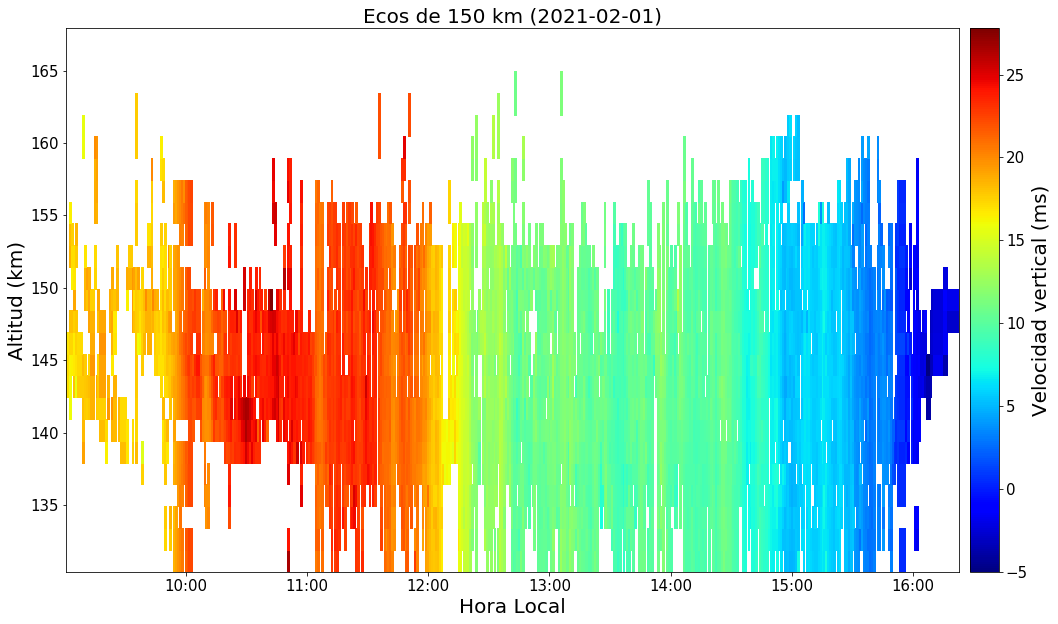

In [11]:
#fig,ax=plt.subplots(1,1)
fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
        
#plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango,v_vertical.T[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (day_index[0].year, day_index[0].month, day_index.day[0]) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Hora Local', fontsize=20)
ax.set_ylabel('Altitud (km)', fontsize=20)
ax.set_title(fig_title, fontsize=20)

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Velocidad vertical (ms)', fontsize=20)
plt.savefig('new-plots-vertical-drift-%d-%02d-%02d.png' % (day_index[0].year, day_index[0].month, day_index.day[0]))

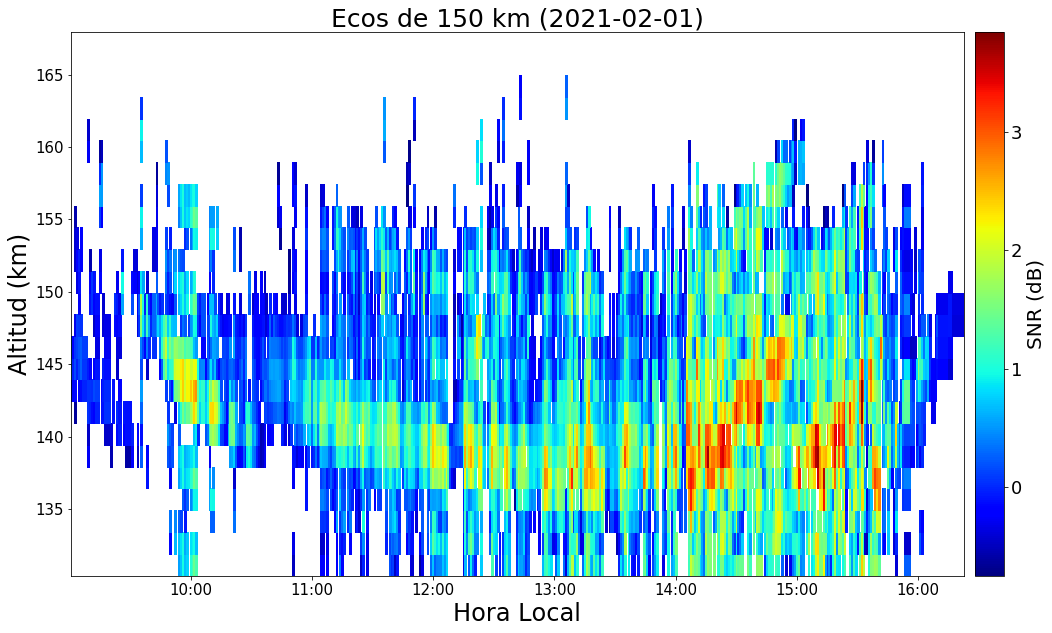

In [12]:
#fig,ax=plt.subplots(1,1)
fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=18
plt.rcParams['xtick.labelsize']=18       
#plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango2D,snl2.T[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (day_index[0].year, day_index[0].month, day_index.day[0]) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Hora Local', fontsize=24)
ax.set_ylabel('Altitud (km)', fontsize=24)
ax.set_title(fig_title, fontsize=25)

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('SNR (dB)', fontsize=20)
plt.savefig('new-plots-snr-vertical-drift-%d-%02d-%02d.pdf' % (day_index[0].year, day_index[0].month, day_index.day[0]))

In [13]:
prev_times = [' ']
k = 0
for time in day_index:
    if prev_times[k] == time:
           print('Same Time')
    else:
        #print 'Different time'
        if not time in prev_times:
            prev_times.append(time)
        prev_time = time


prev_times = prev_times[1:]
num_diff_times = len(prev_times)
print(num_diff_times)

502


### Monthly stuff

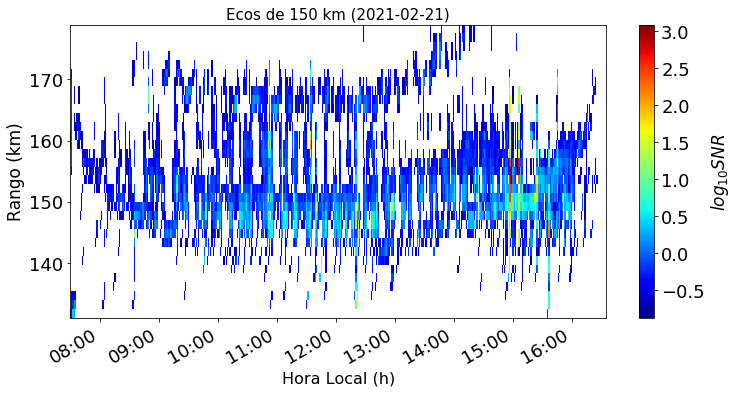

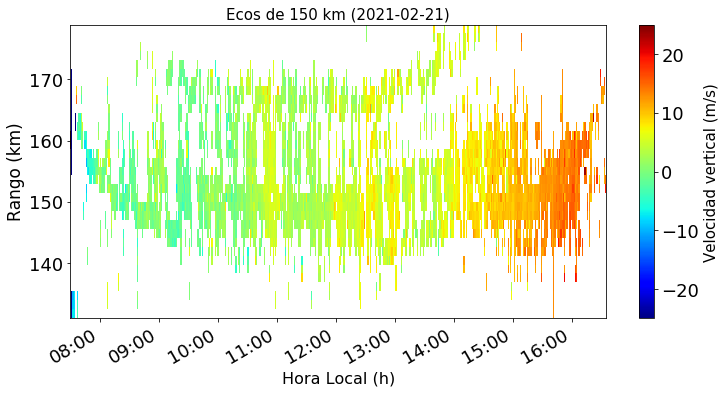

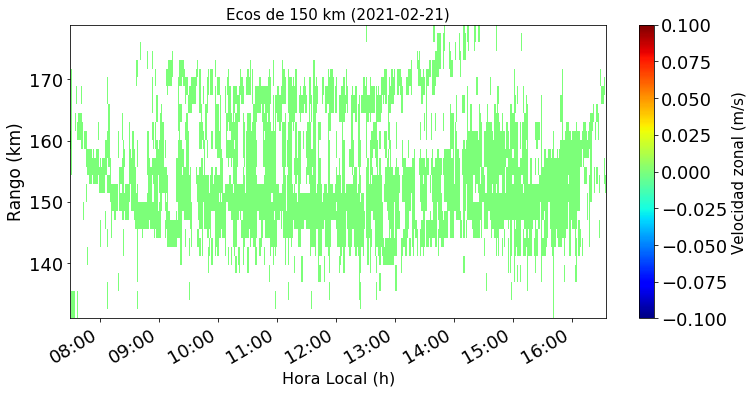

447
Vertical Average shape:  (447,) (447,) 2021-02-21 07:29:40 2021-02-21 16:35:01


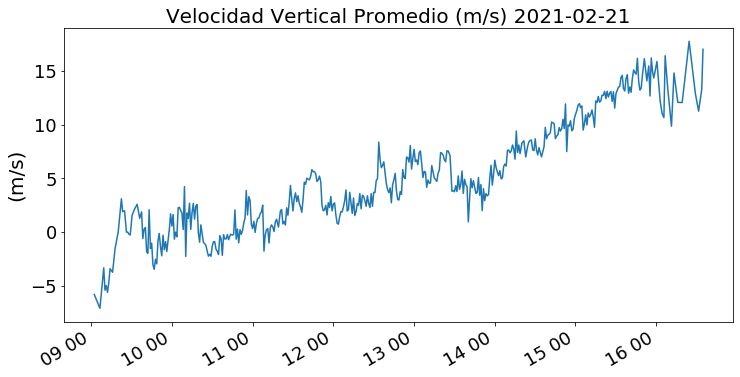

Range array shape:  (4539,)


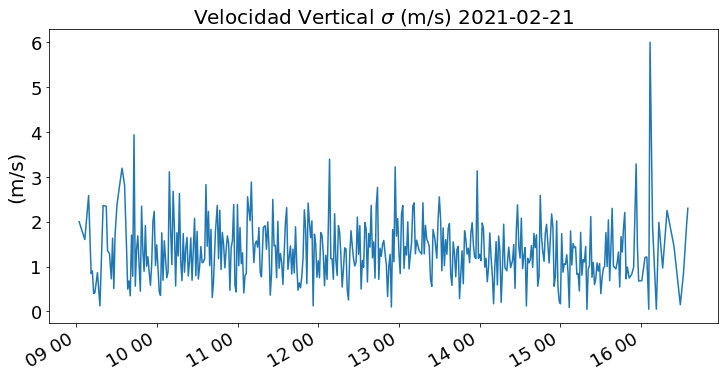

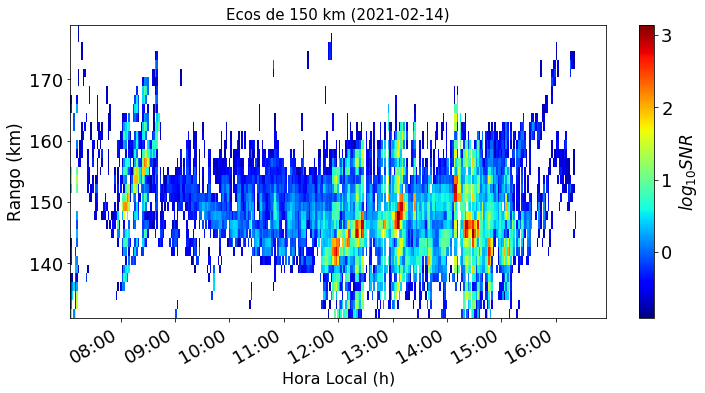

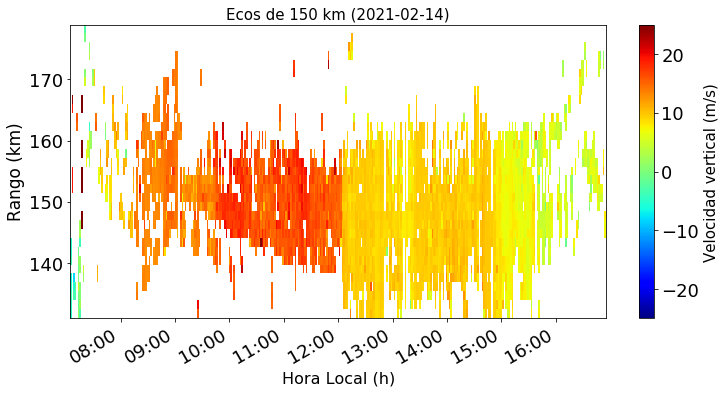

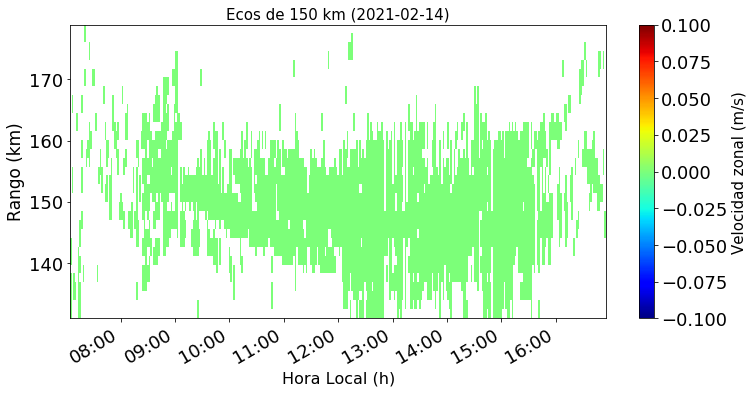

341
Vertical Average shape:  (341,) (341,) 2021-02-14 07:04:30 2021-02-14 16:55:25


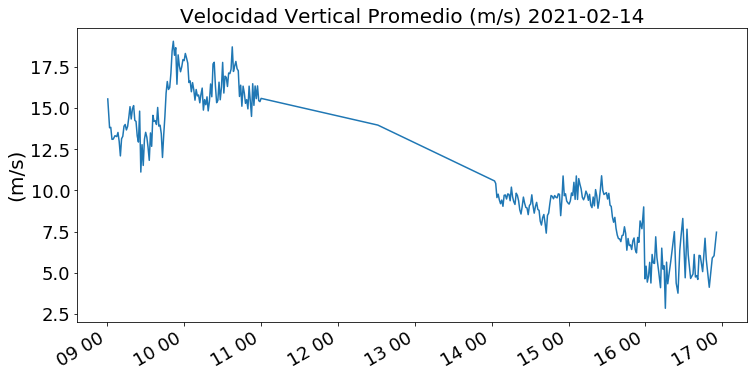

Range array shape:  (3946,)


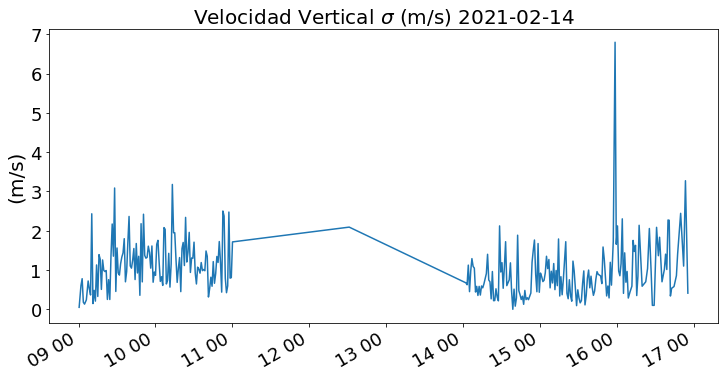

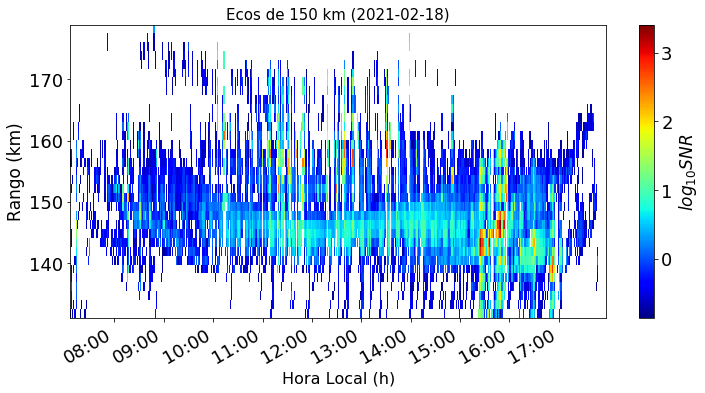

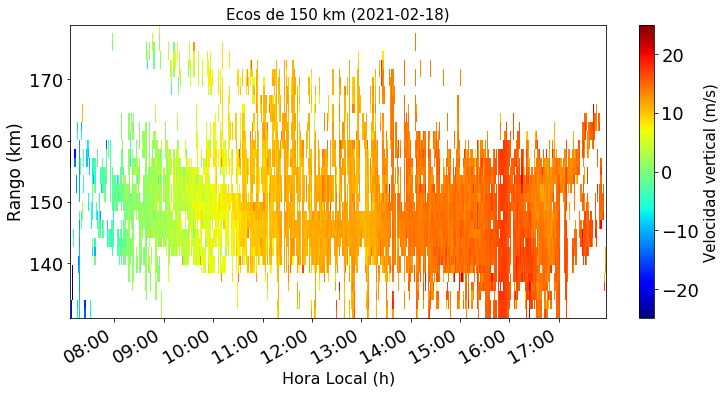

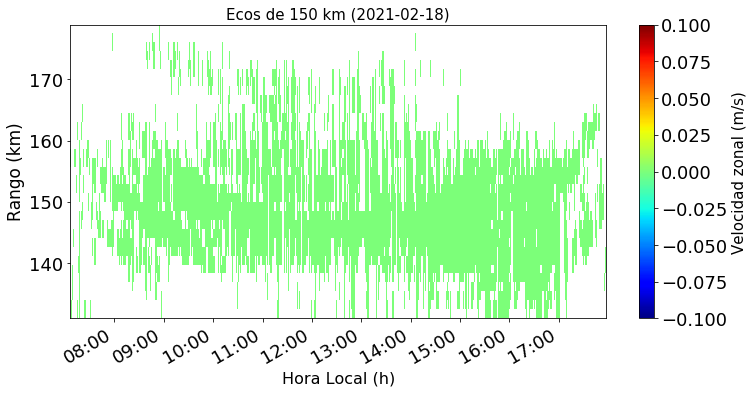

482
Vertical Average shape:  (482,) (482,) 2021-02-18 07:06:21 2021-02-18 17:57:19


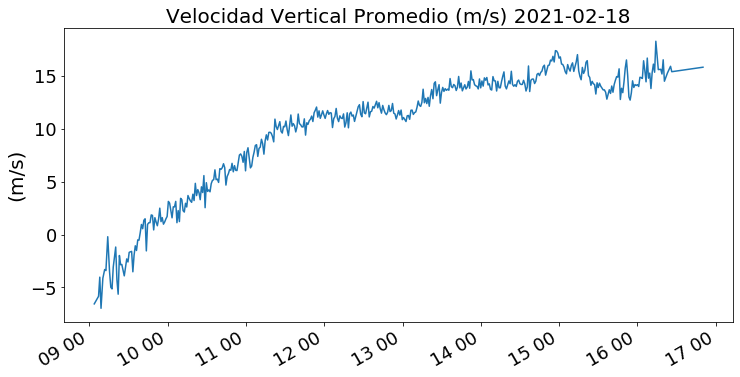

Range array shape:  (6256,)


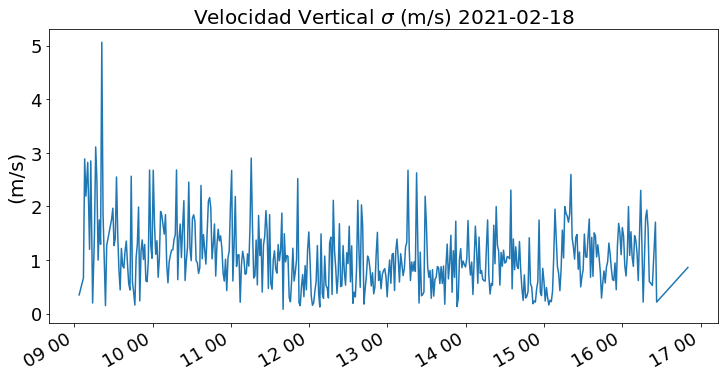

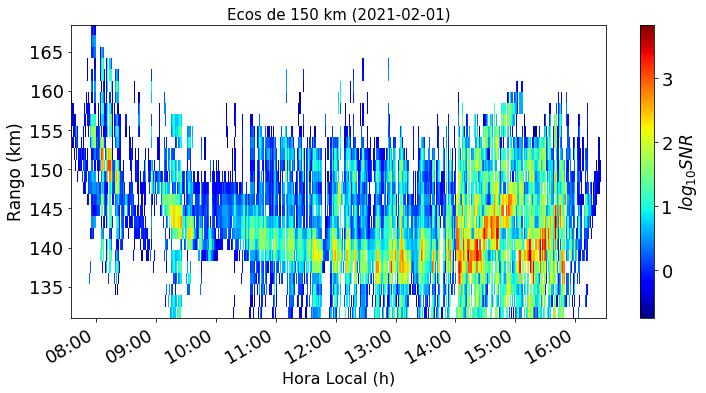

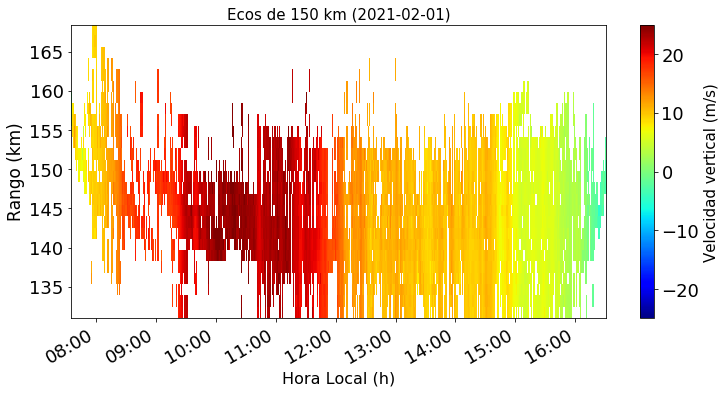

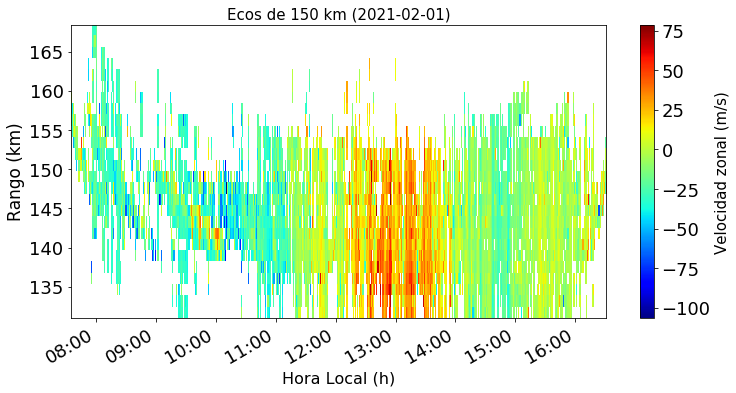

502
Vertical Average shape:  (502,) (502,) 2021-02-01 07:34:34 2021-02-01 16:31:02


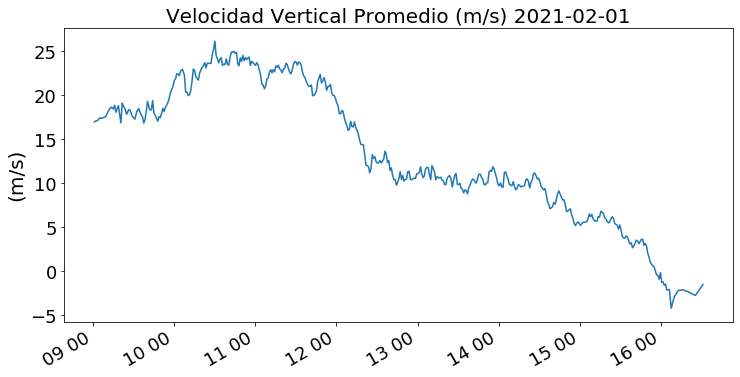

Range array shape:  (5742,)


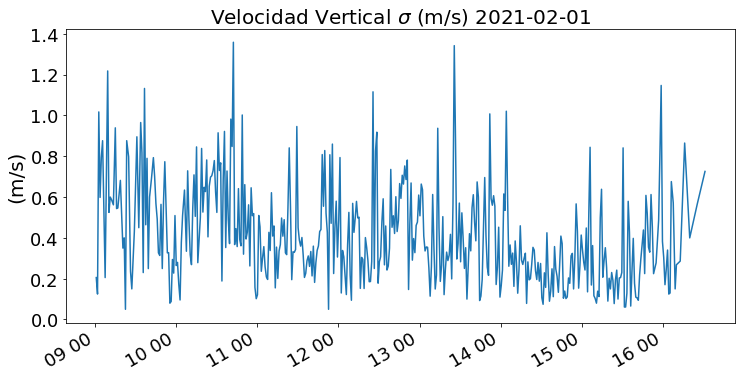

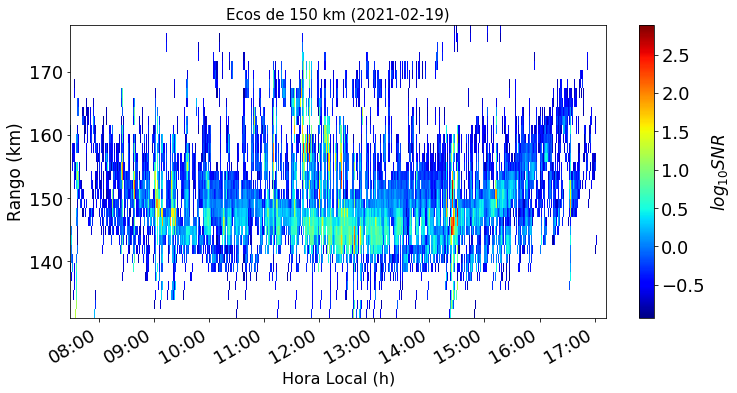

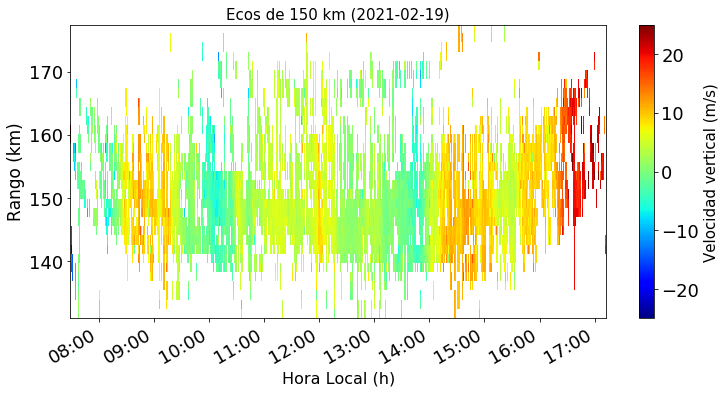

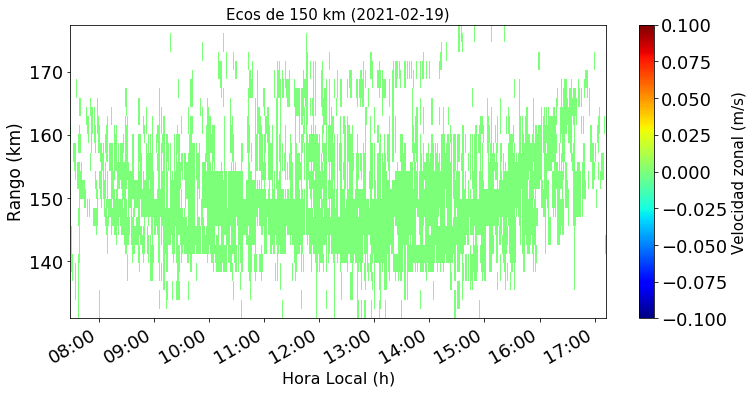

516
Vertical Average shape:  (516,) (516,) 2021-02-19 07:28:59 2021-02-19 17:12:23


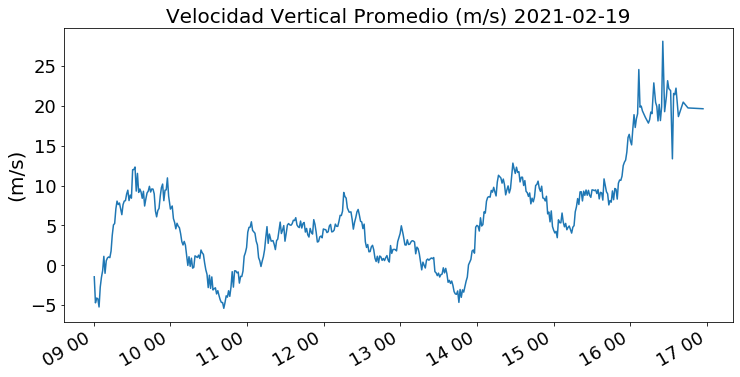

Range array shape:  (5722,)


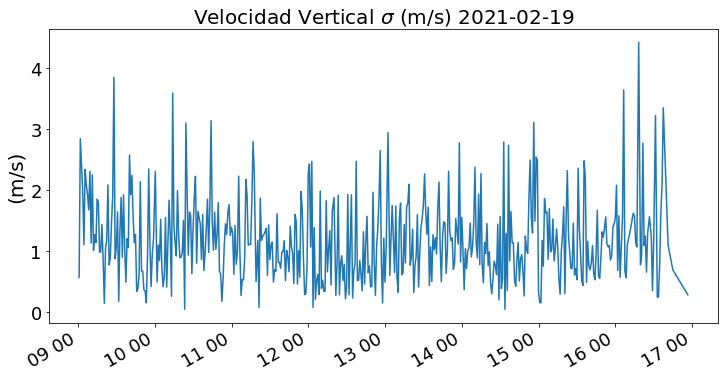

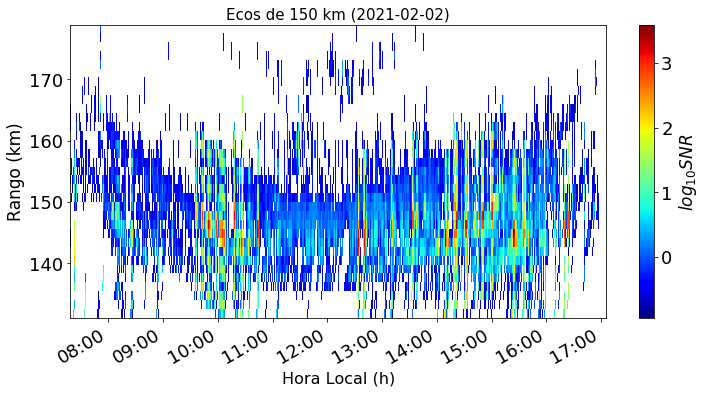

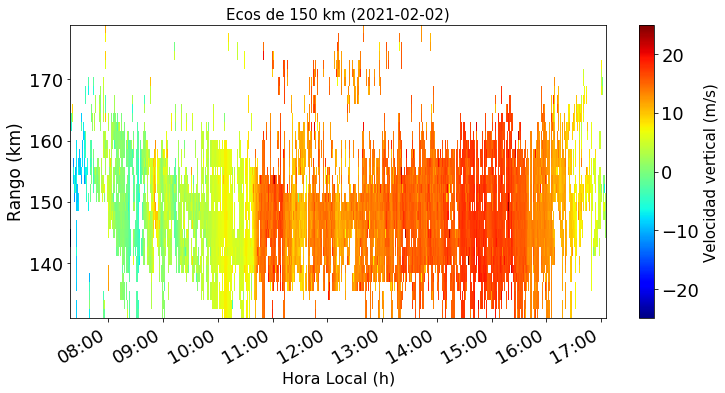

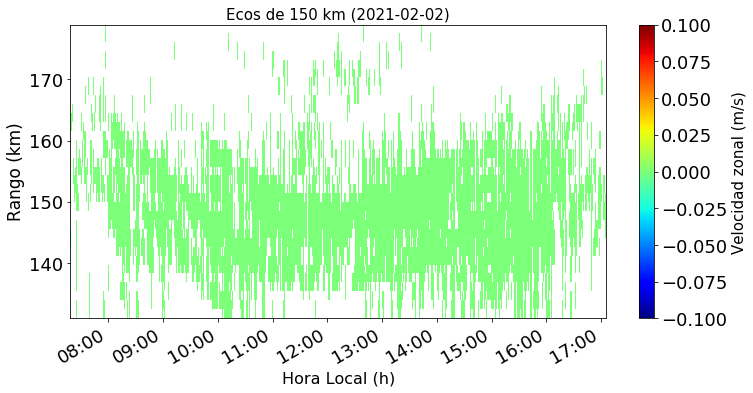

569
Vertical Average shape:  (569,) (569,) 2021-02-02 07:18:15 2021-02-02 17:05:24


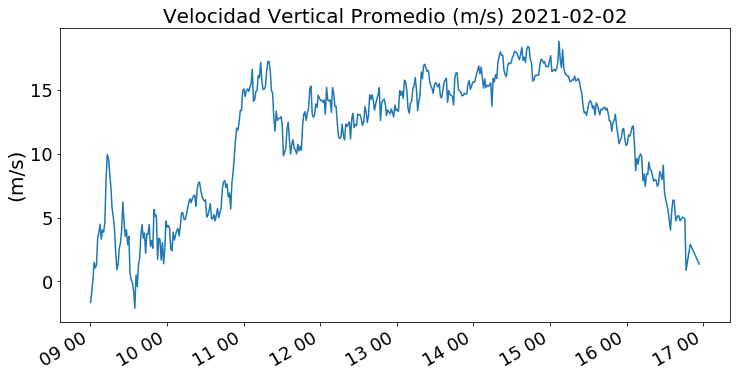

Range array shape:  (7389,)


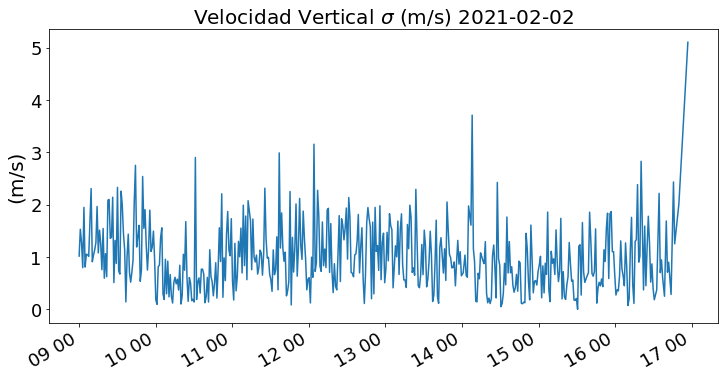

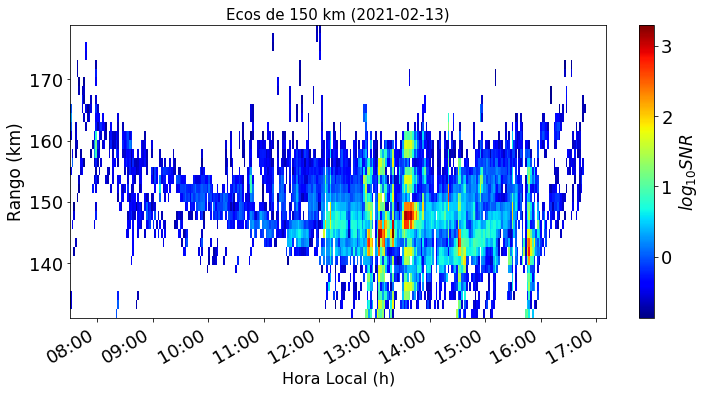

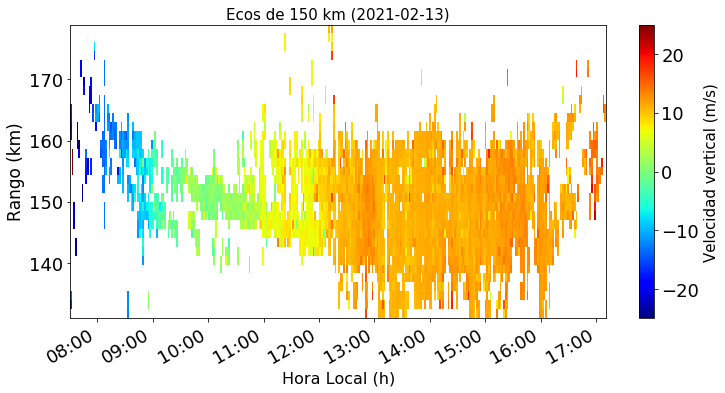

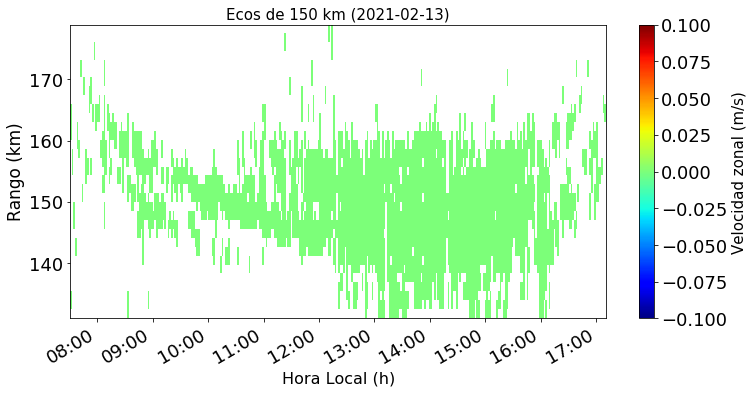

318
Vertical Average shape:  (318,) (318,) 2021-02-13 07:31:07 2021-02-13 17:10:19


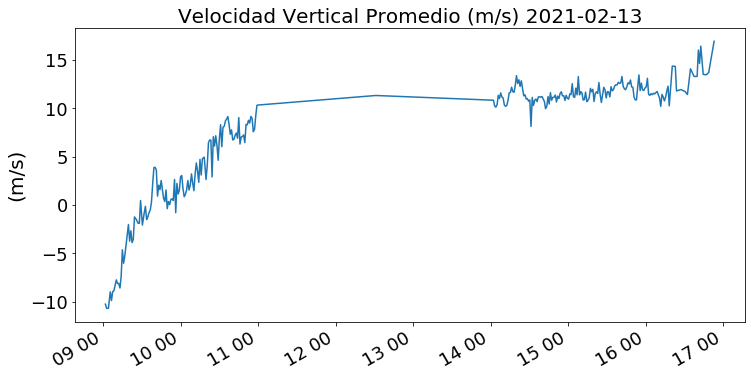

Range array shape:  (3309,)


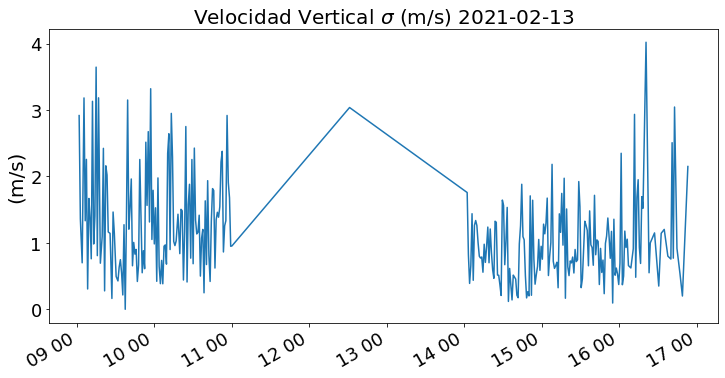

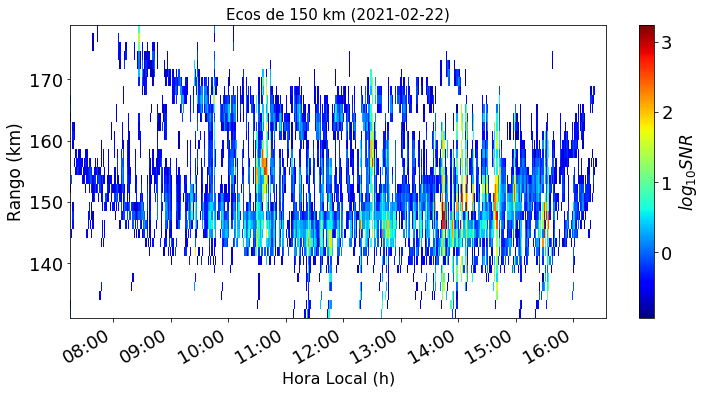

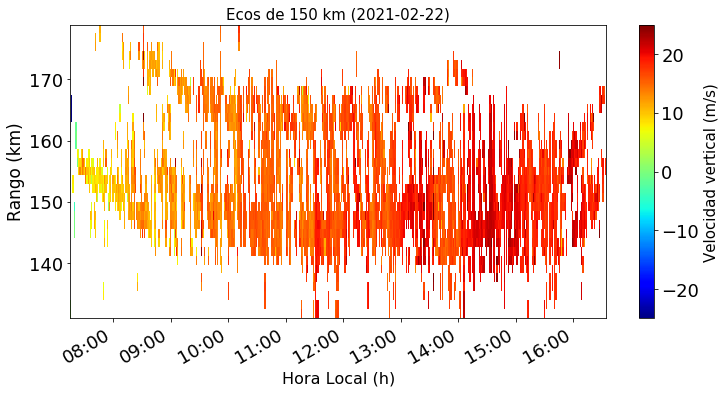

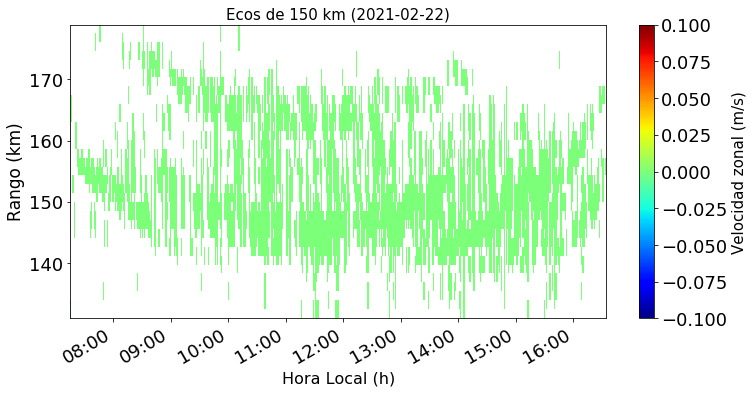

455
Vertical Average shape:  (455,) (455,) 2021-02-22 07:15:31 2021-02-22 16:34:02


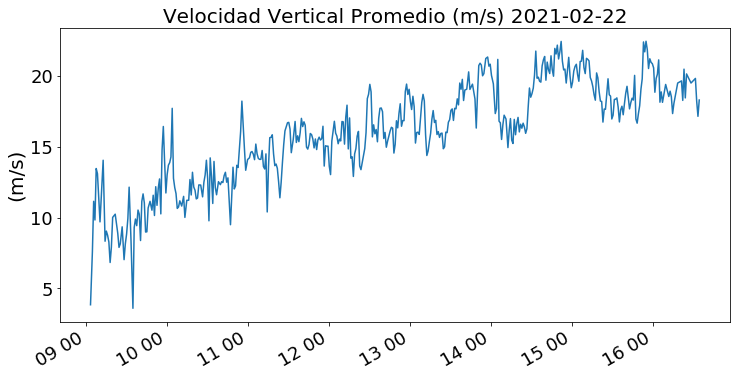

Range array shape:  (4734,)


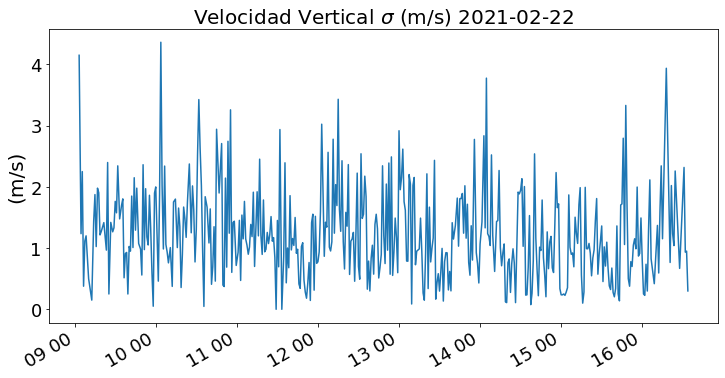

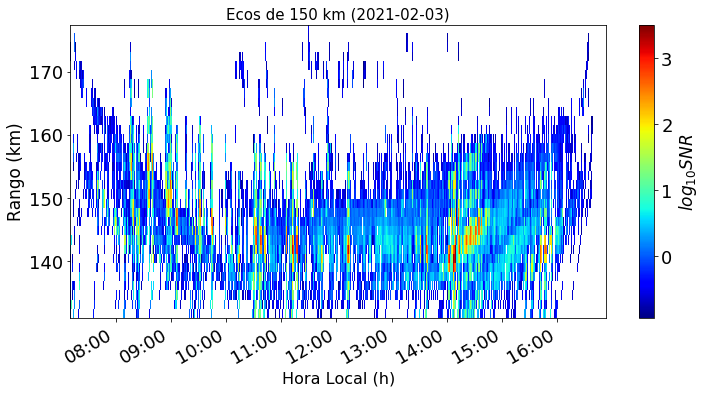

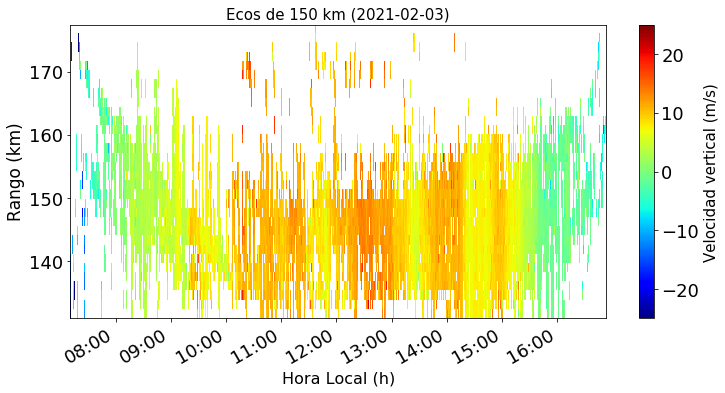

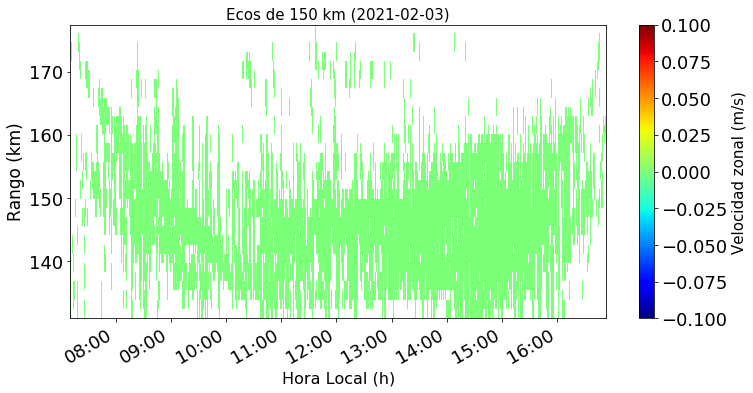

539
Vertical Average shape:  (539,) (539,) 2021-02-03 07:10:50 2021-02-03 16:52:49


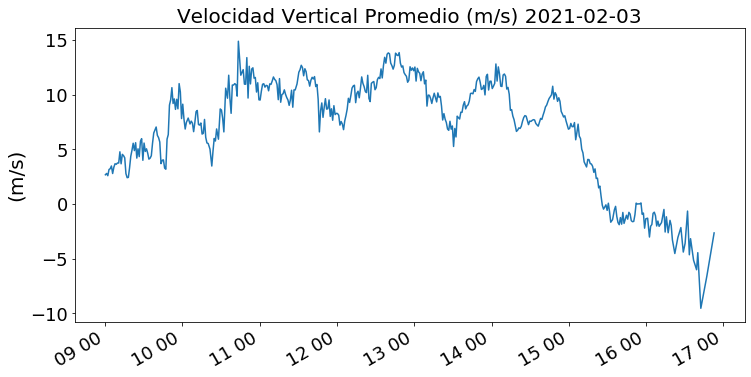

Range array shape:  (6839,)


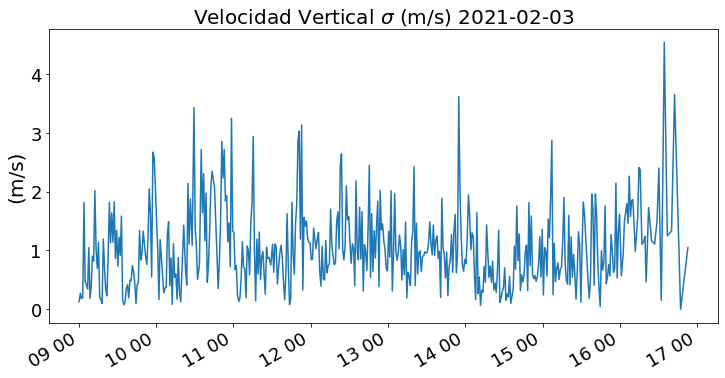

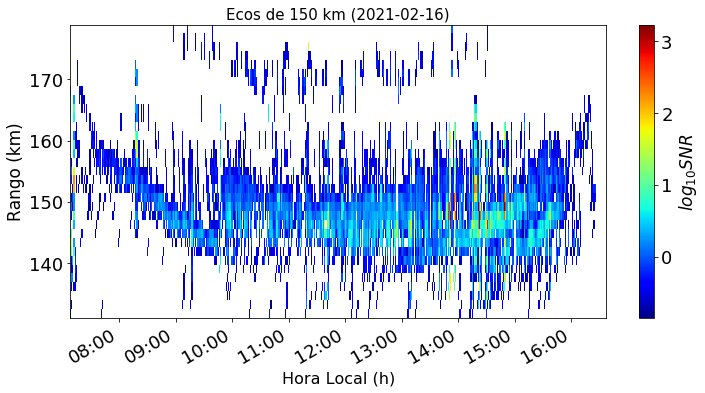

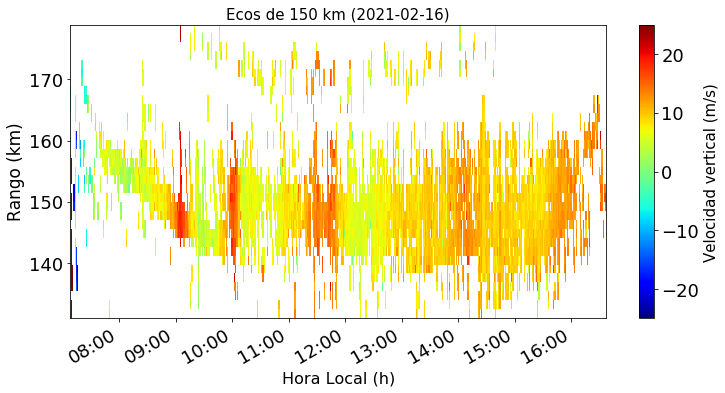

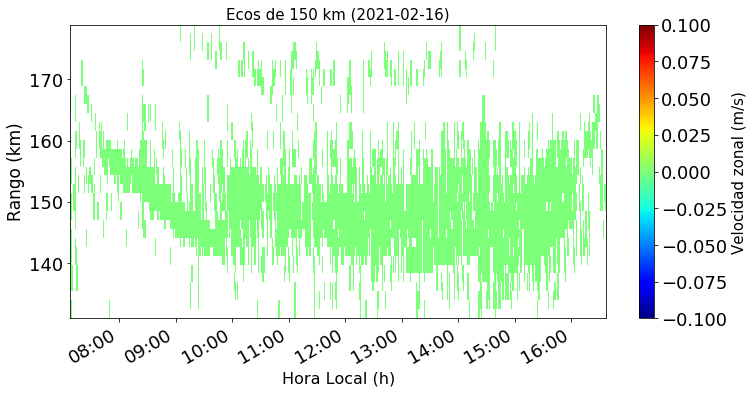

468
Vertical Average shape:  (468,) (468,) 2021-02-16 07:07:56 2021-02-16 16:37:07


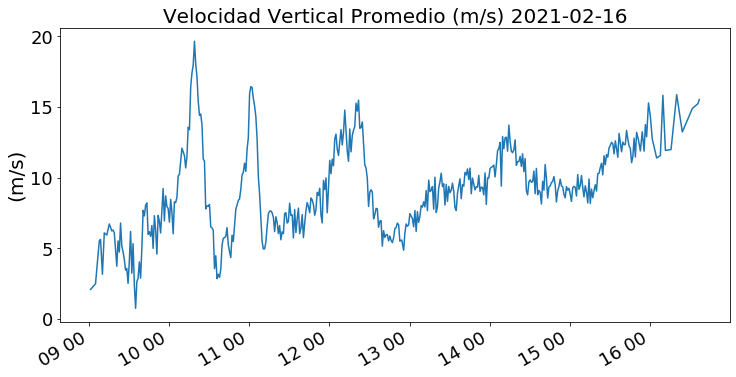

Range array shape:  (4718,)


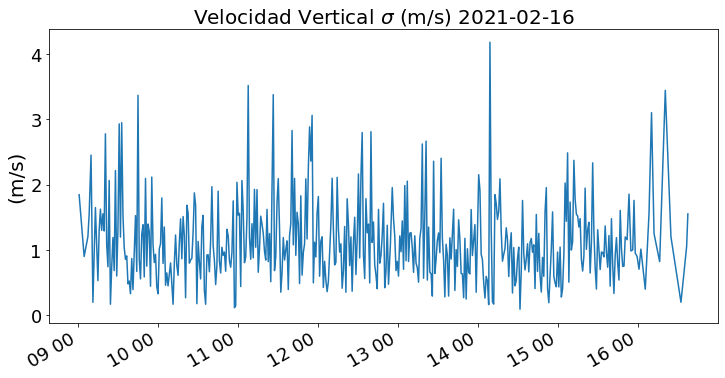

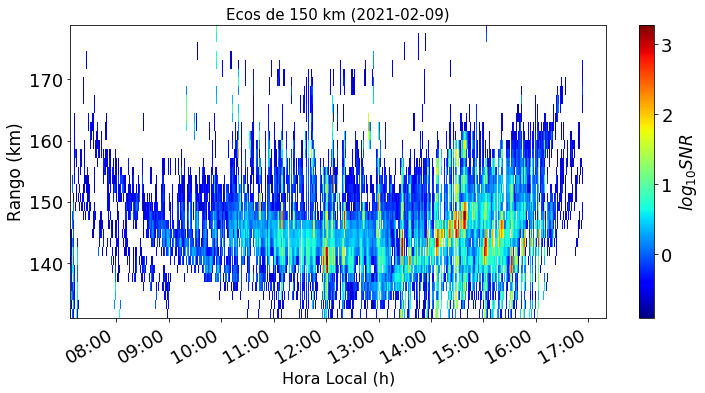

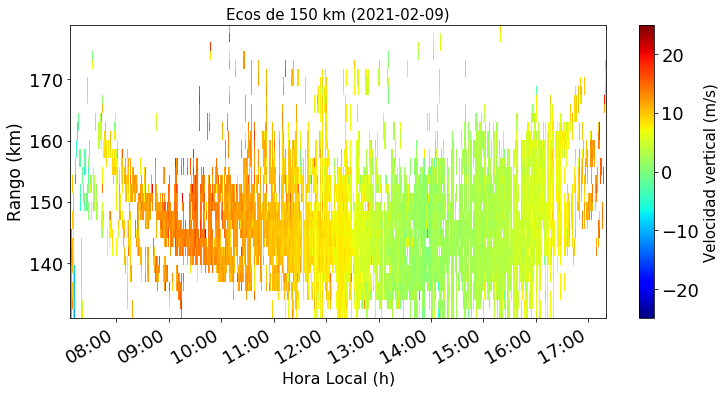

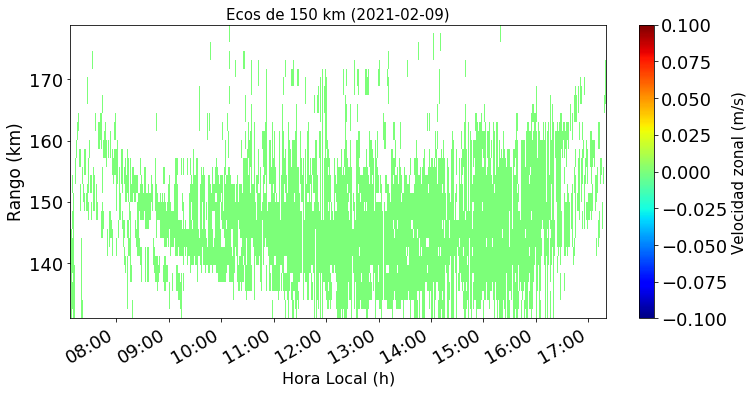

543
Vertical Average shape:  (543,) (543,) 2021-02-09 07:07:36 2021-02-09 17:20:06


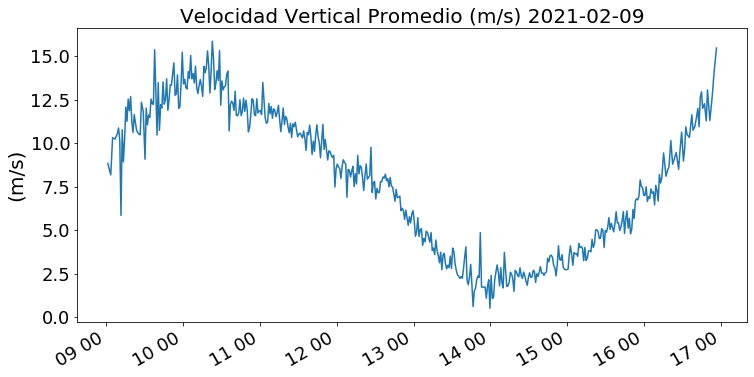

Range array shape:  (6336,)


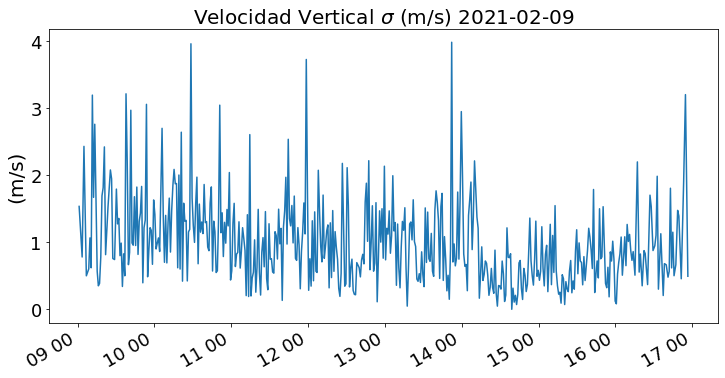

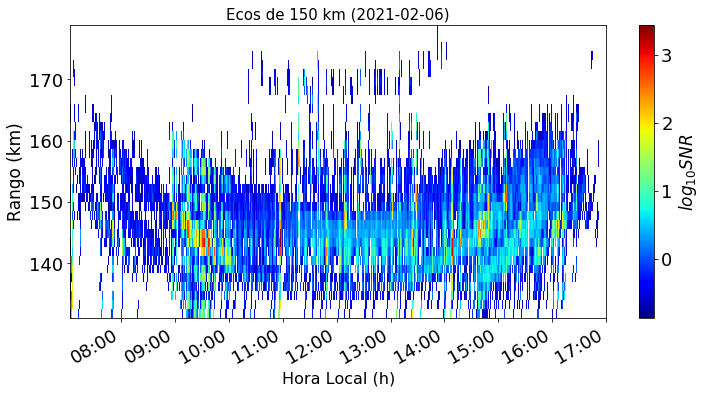

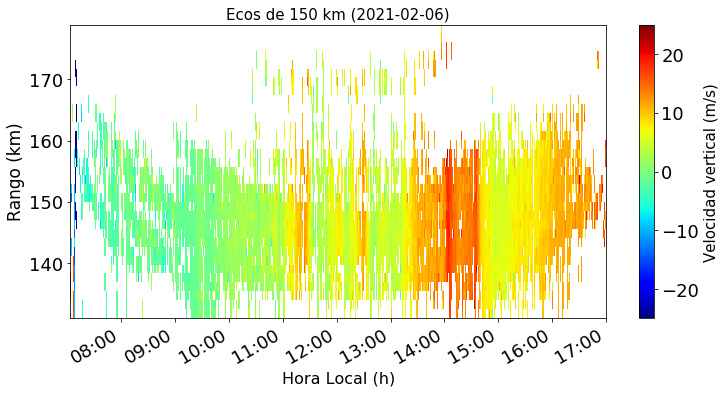

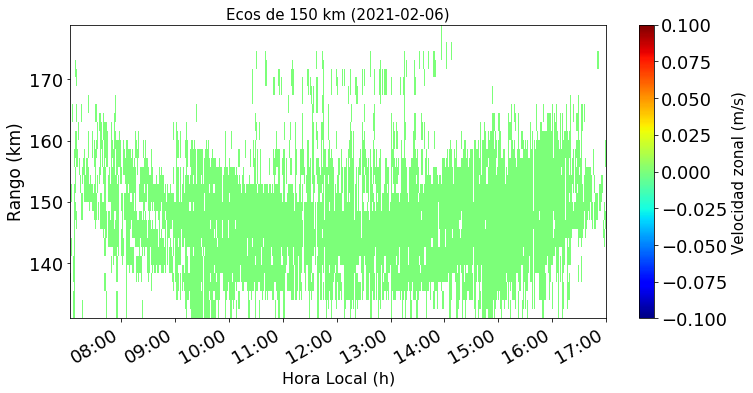

557
Vertical Average shape:  (557,) (557,) 2021-02-06 07:03:06 2021-02-06 17:00:05


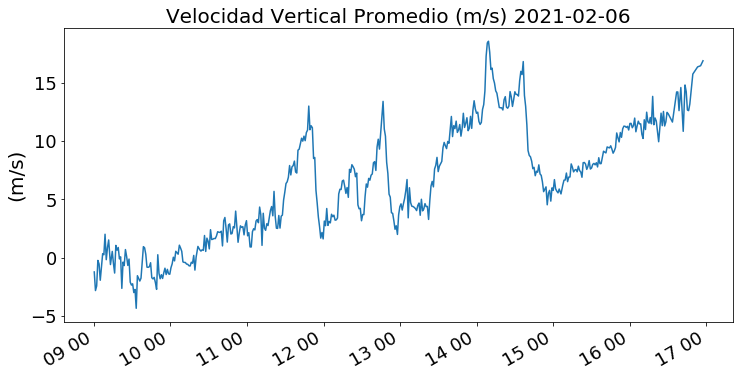

Range array shape:  (7376,)


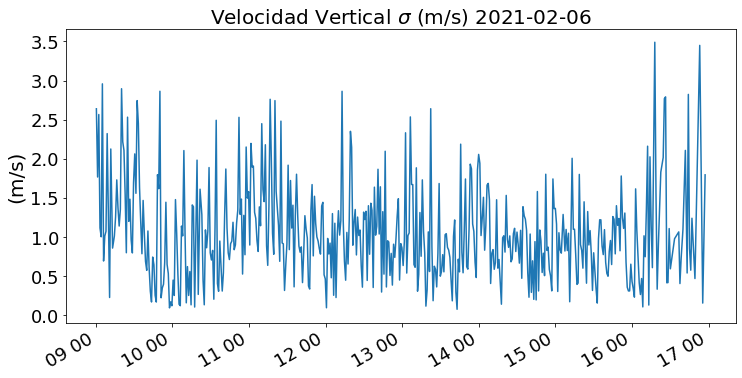

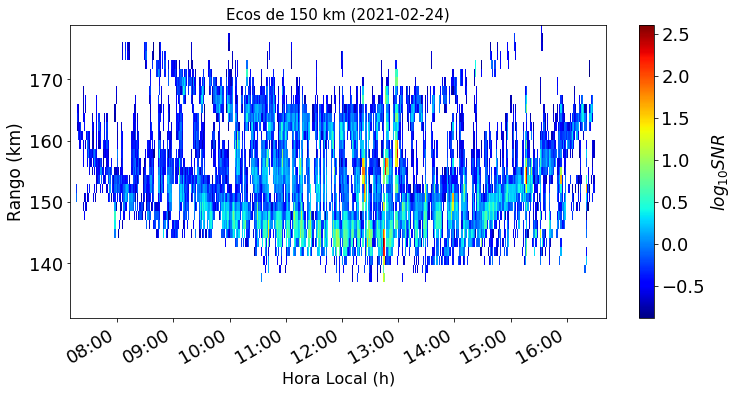

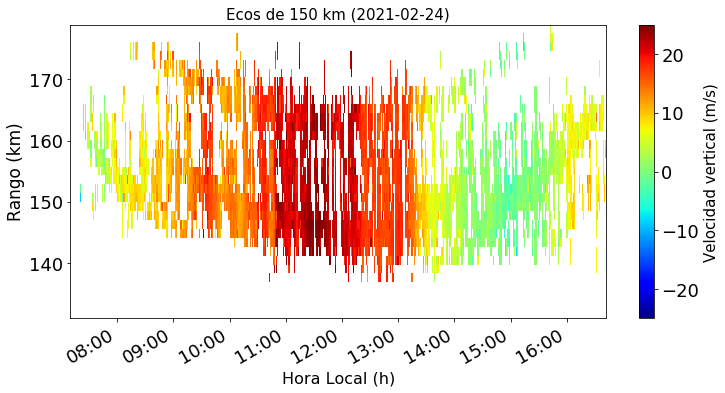

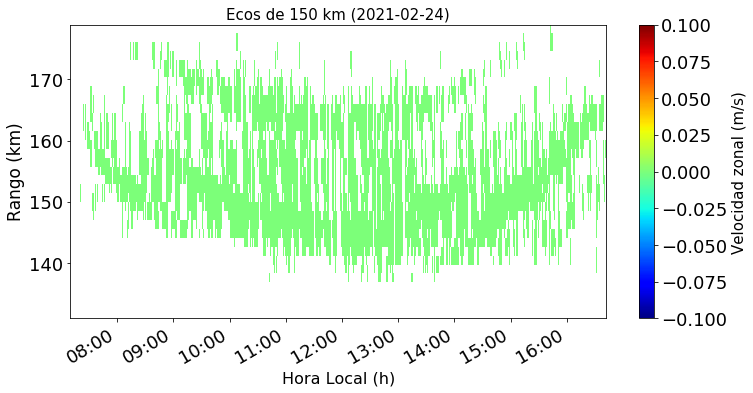

471
Vertical Average shape:  (471,) (471,) 2021-02-24 07:10:06 2021-02-24 16:41:45


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


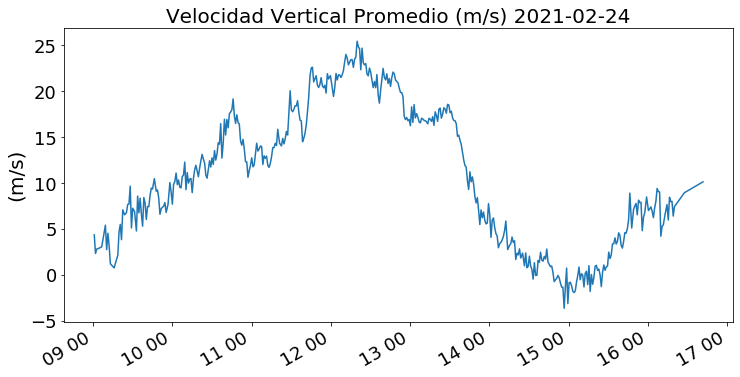

Range array shape:  (5166,)


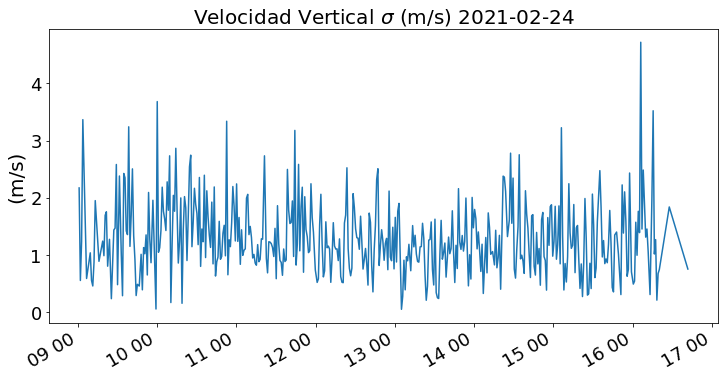

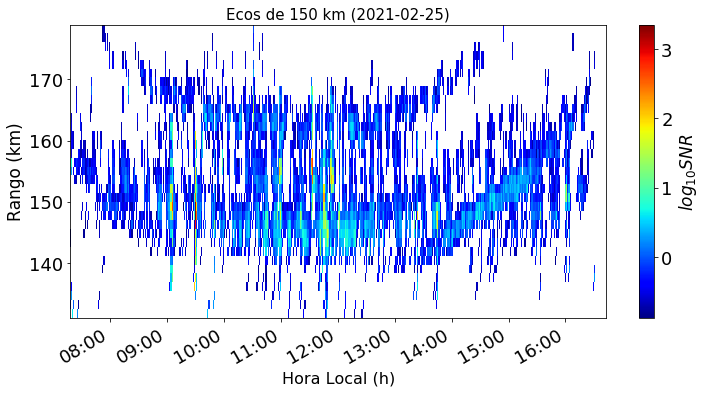

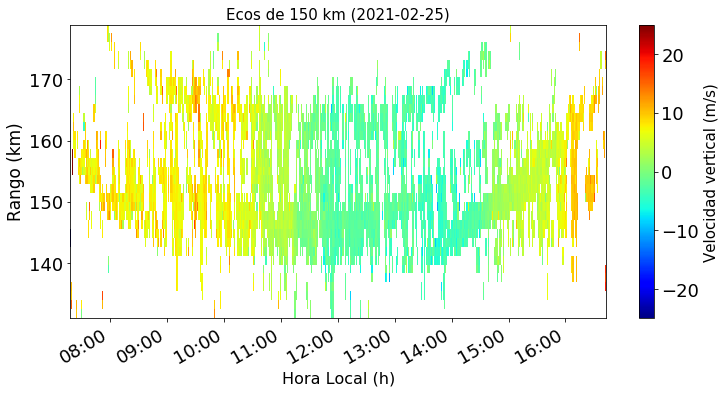

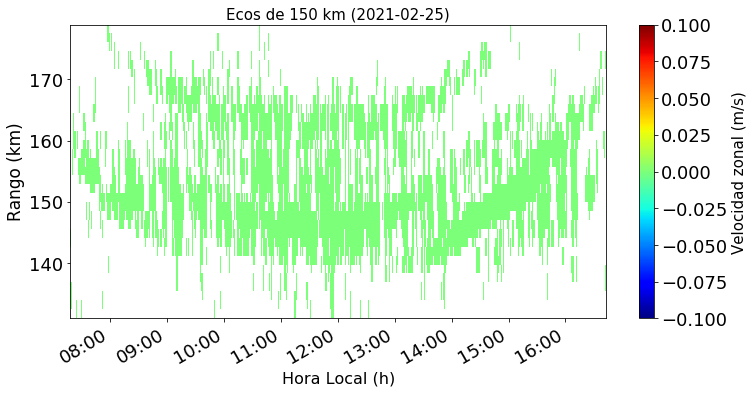

480
Vertical Average shape:  (480,) (480,) 2021-02-25 07:17:40 2021-02-25 16:42:45


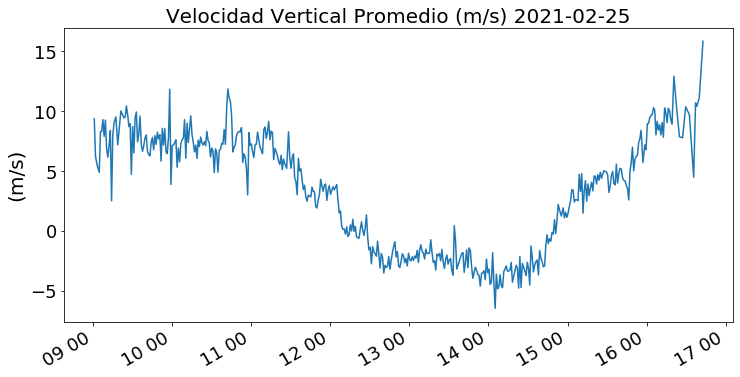

Range array shape:  (4998,)


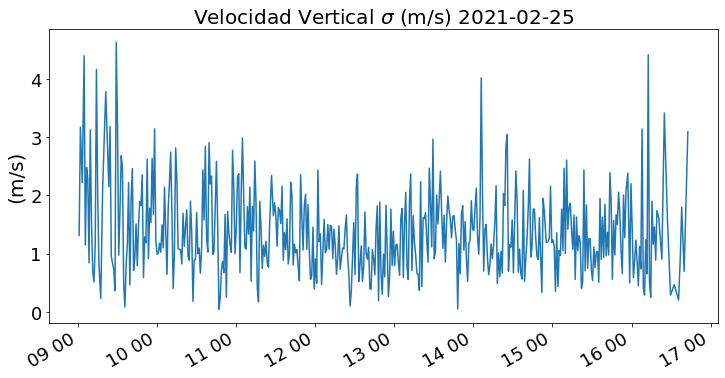

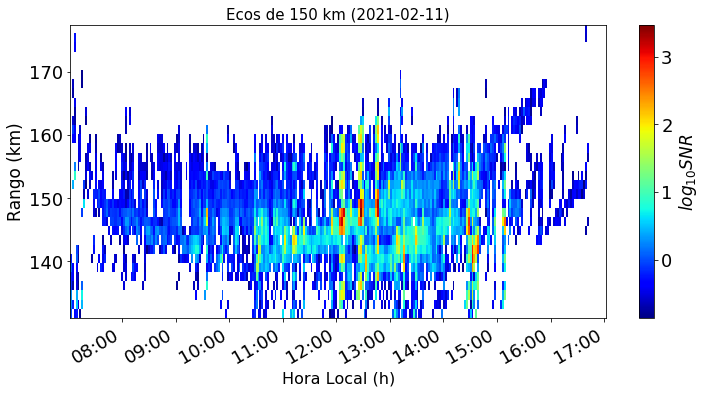

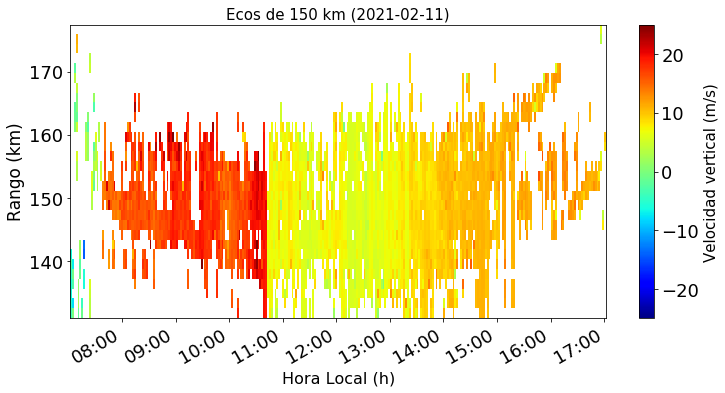

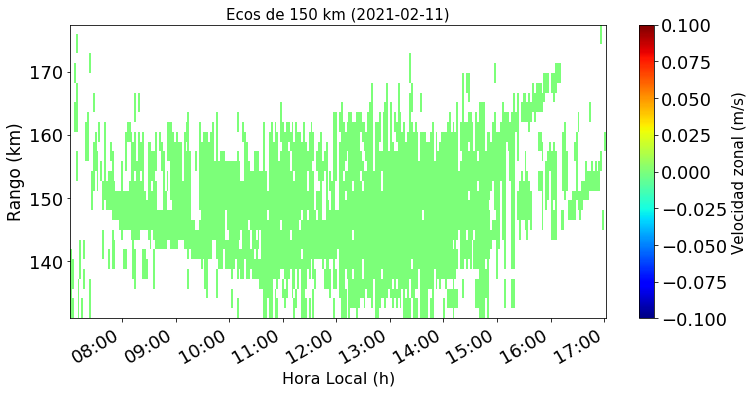

283
Vertical Average shape:  (283,) (283,) 2021-02-11 07:02:04 2021-02-11 17:02:06


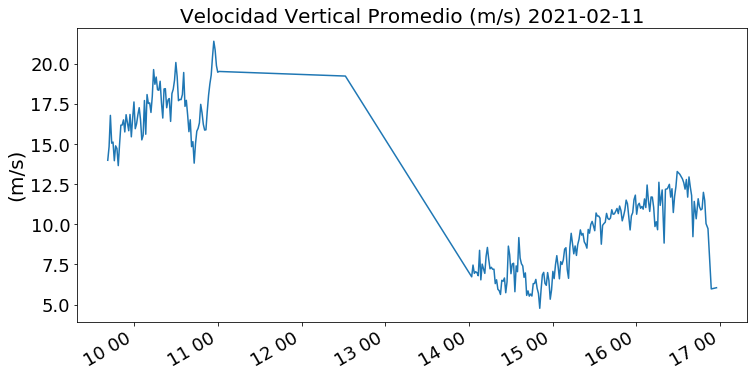

Range array shape:  (3264,)


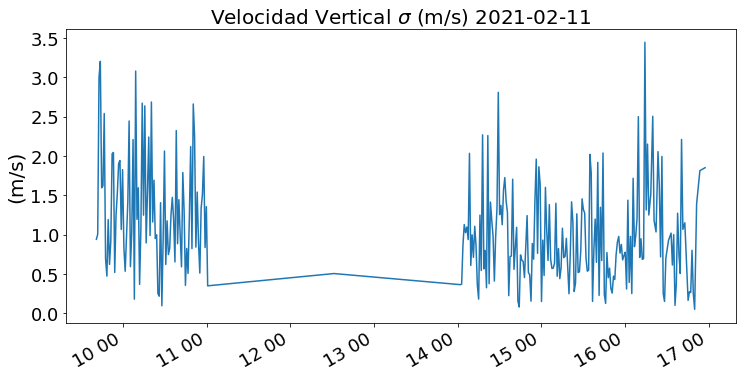

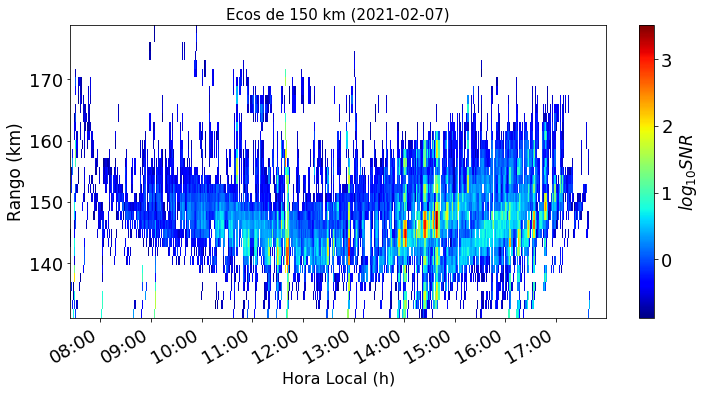

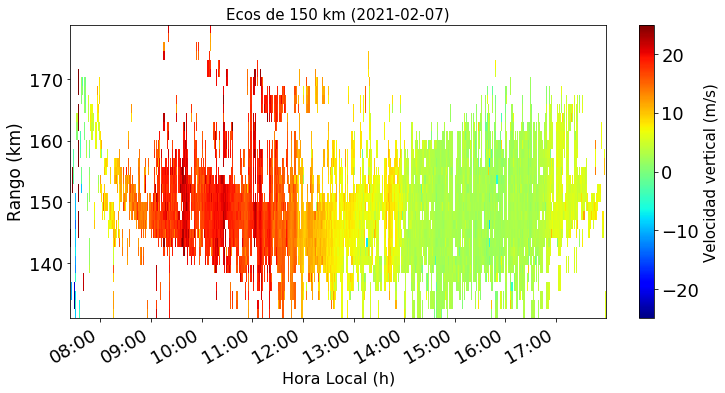

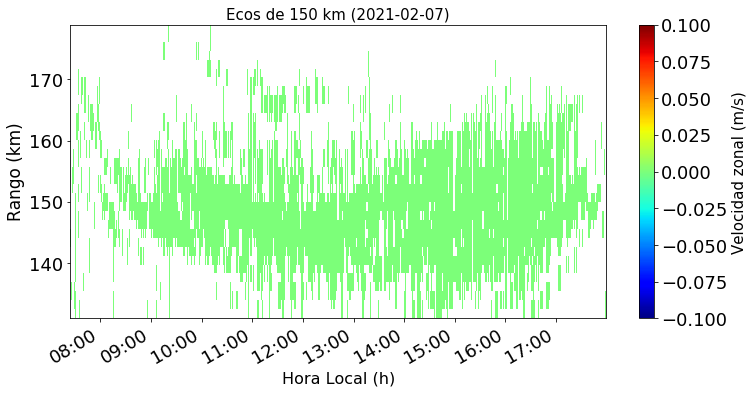

499
Vertical Average shape:  (499,) (499,) 2021-02-07 07:24:16 2021-02-07 17:59:17


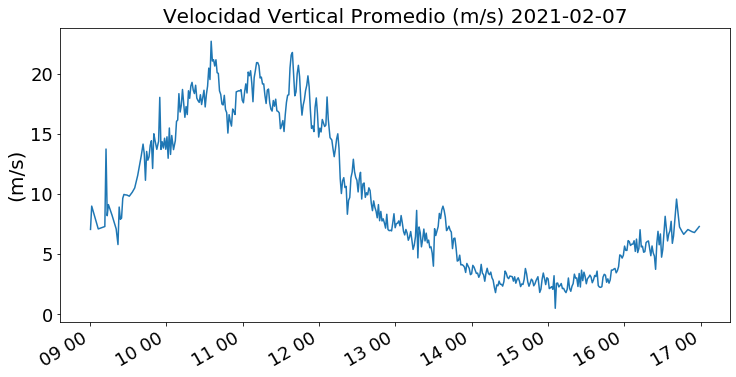

Range array shape:  (6010,)


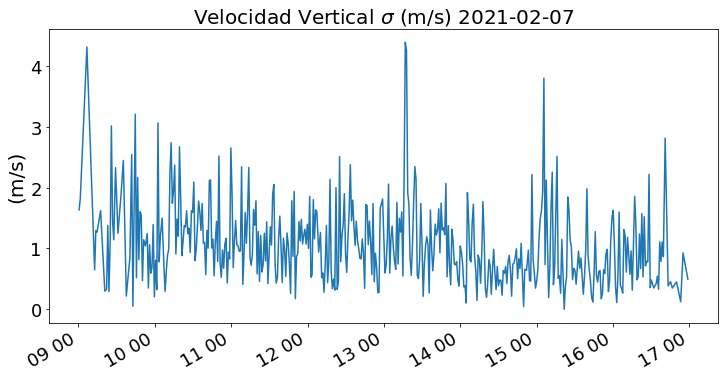

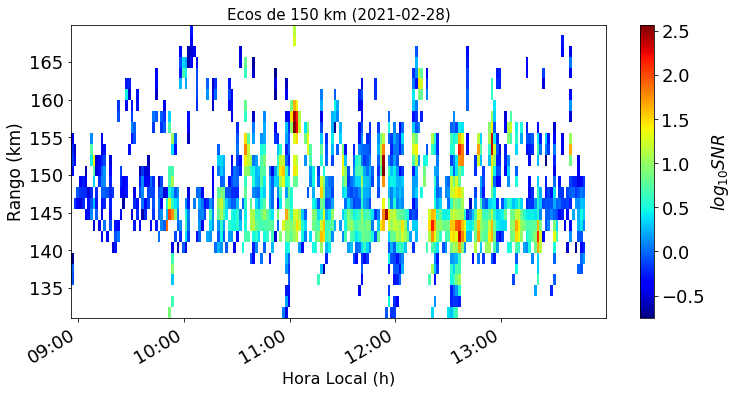

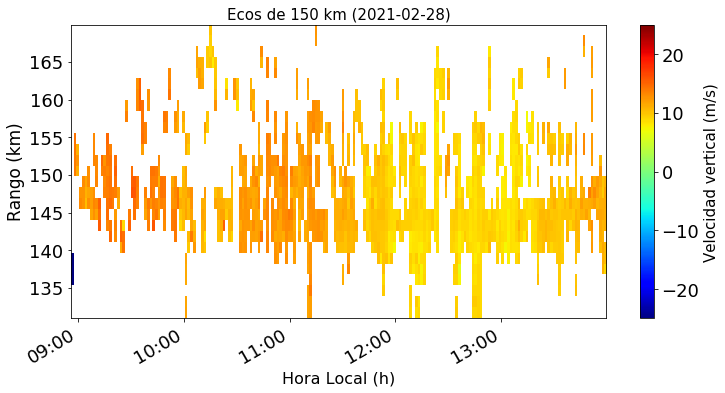

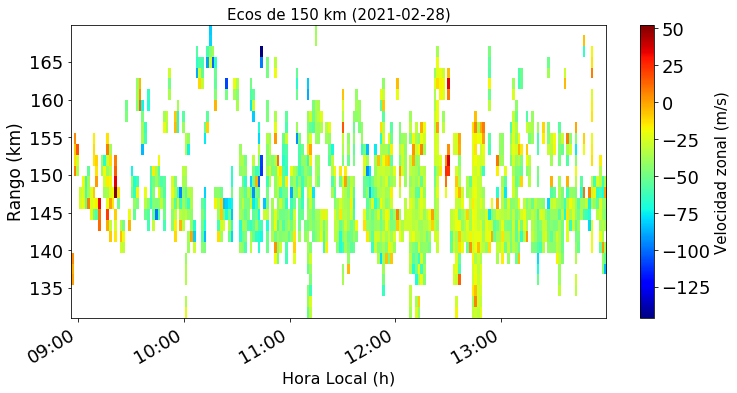

198
Vertical Average shape:  (198,) (198,) 2021-02-28 08:55:32 2021-02-28 13:59:41


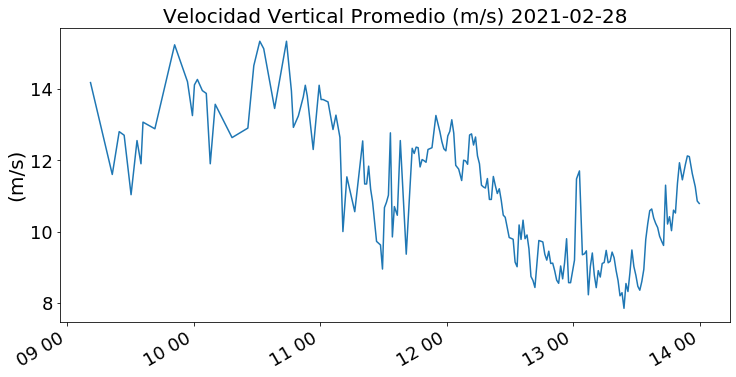

Range array shape:  (1474,)


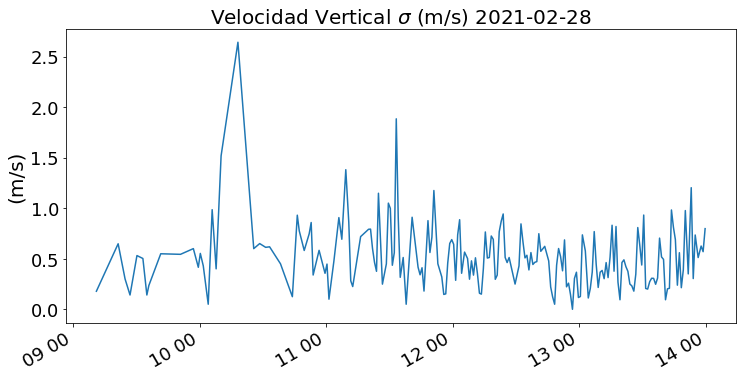

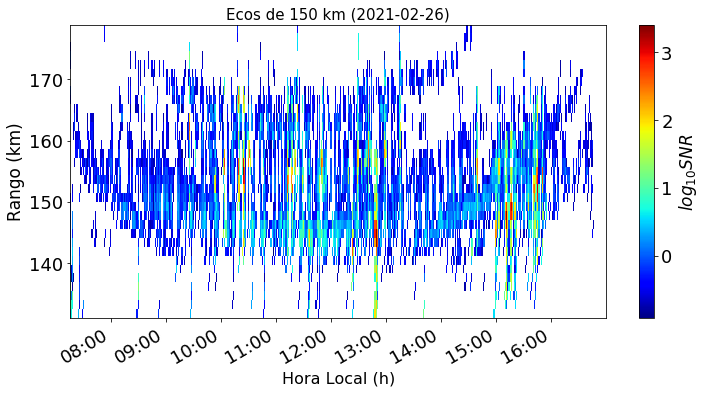

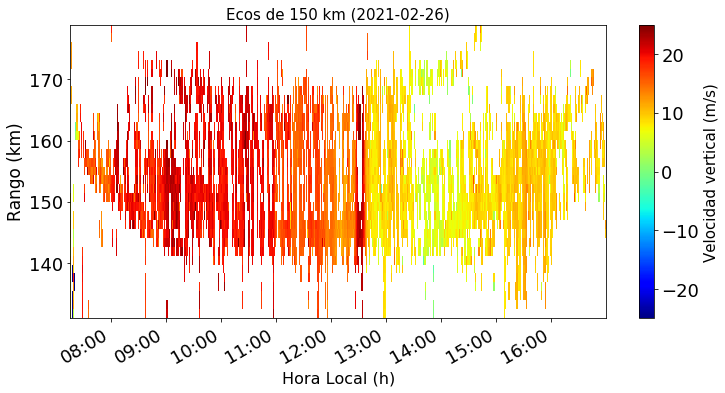

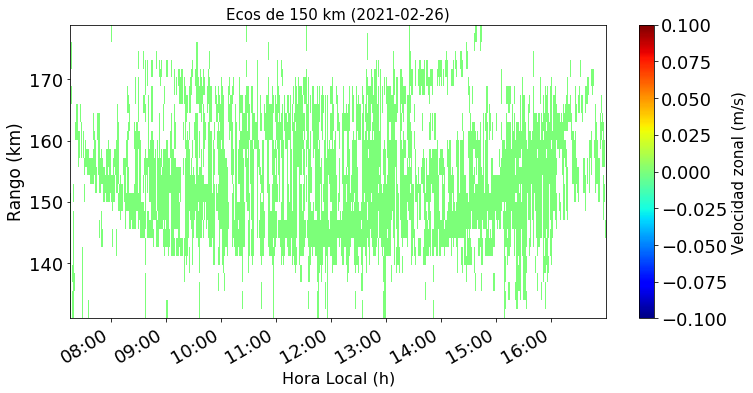

500
Vertical Average shape:  (500,) (500,) 2021-02-26 07:15:53 2021-02-26 16:59:45


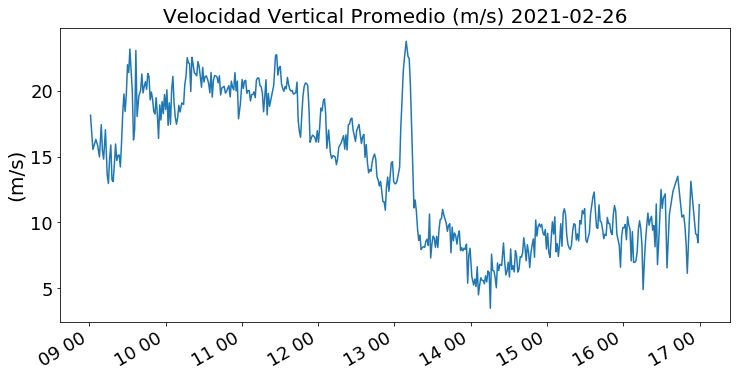

Range array shape:  (5493,)


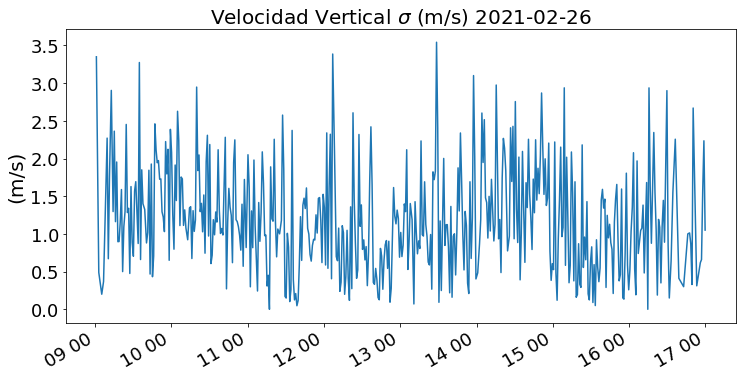

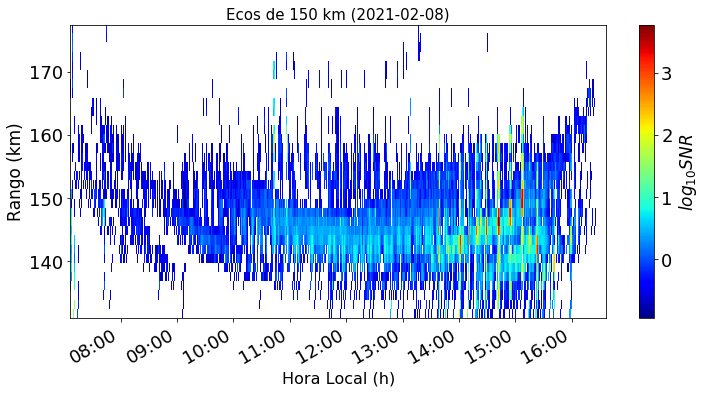

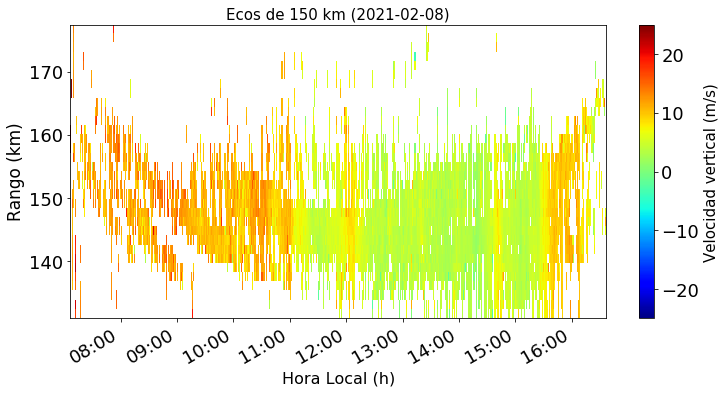

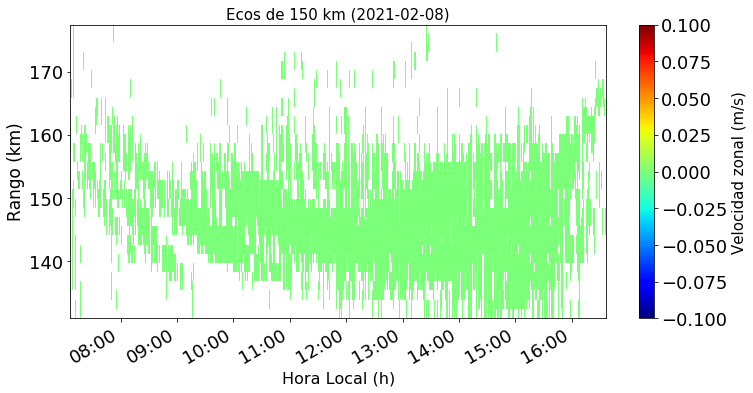

529
Vertical Average shape:  (529,) (529,) 2021-02-08 07:06:30 2021-02-08 16:36:20


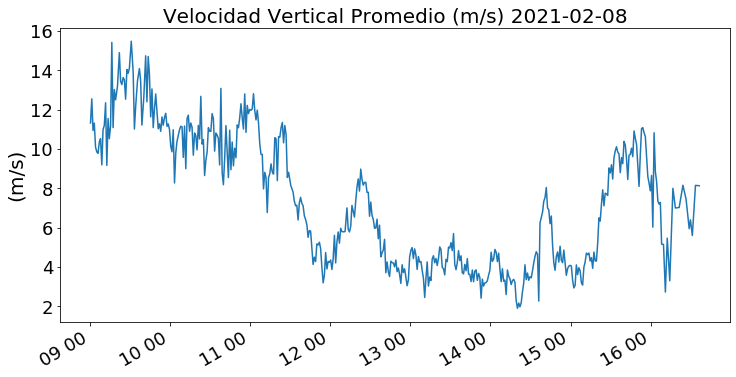

Range array shape:  (5999,)


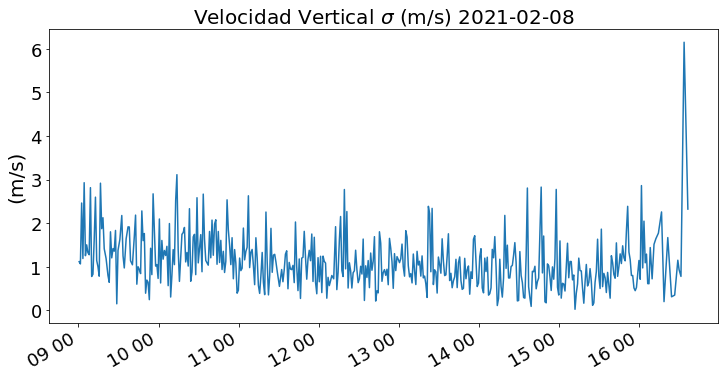

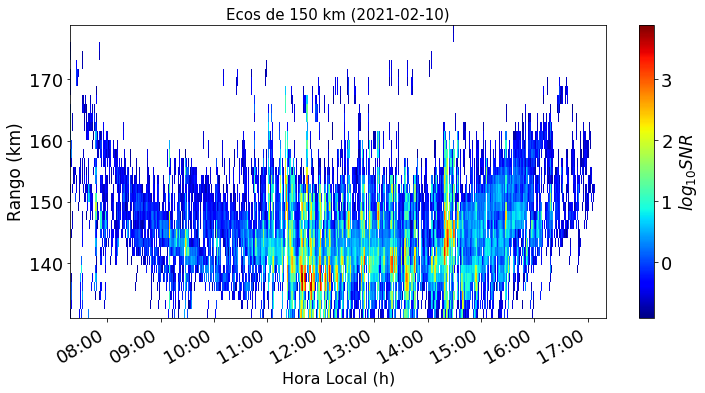

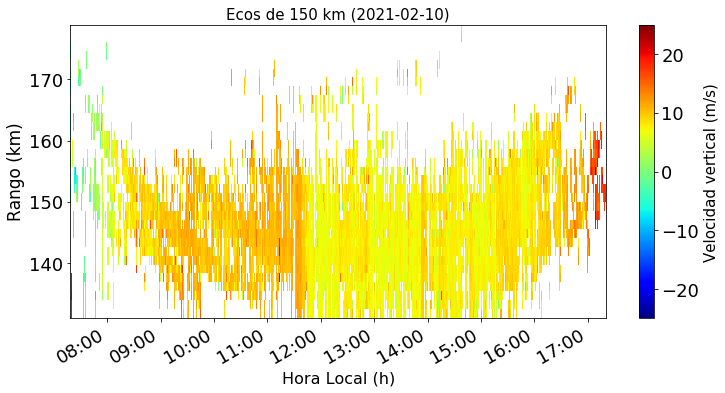

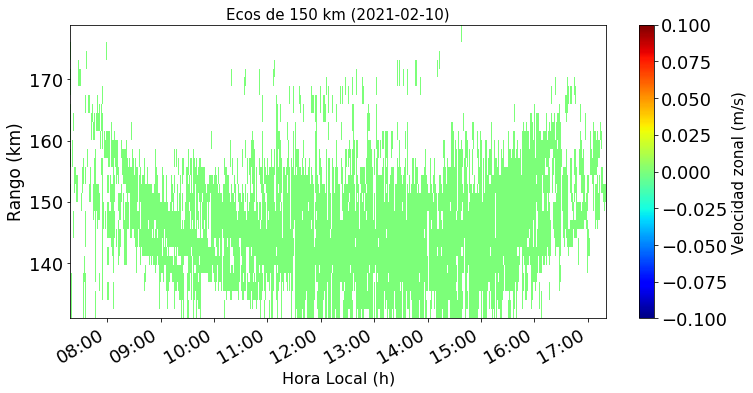

578
Vertical Average shape:  (578,) (578,) 2021-02-10 07:18:26 2021-02-10 17:20:36


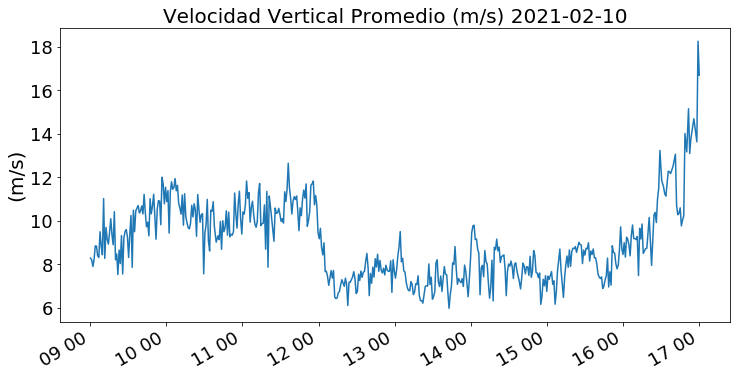

Range array shape:  (7237,)


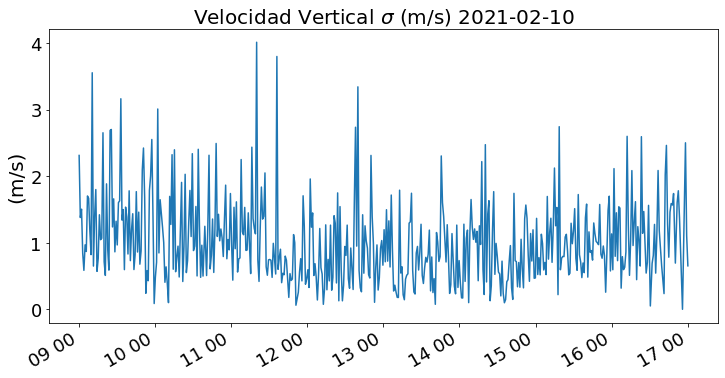

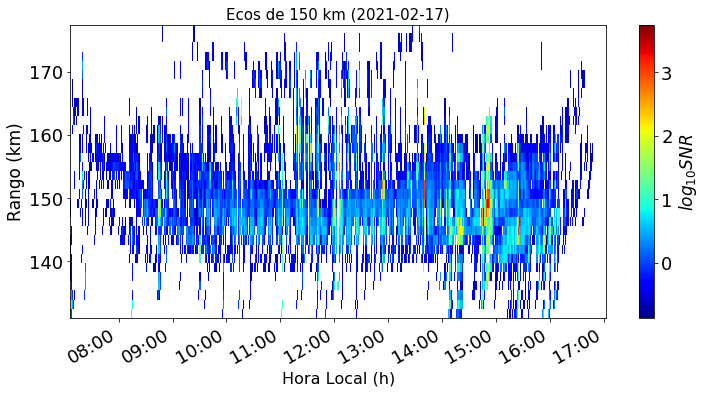

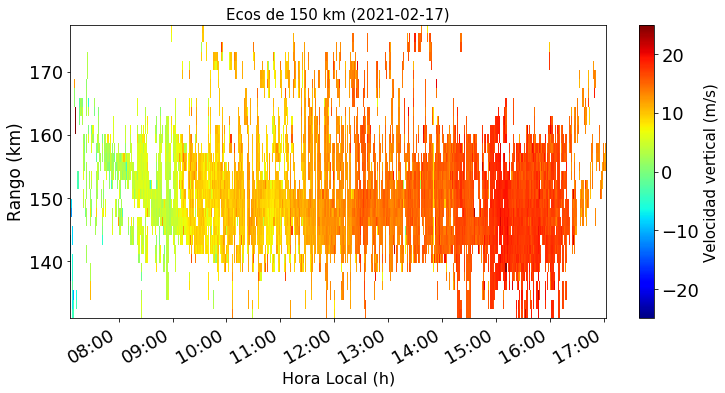

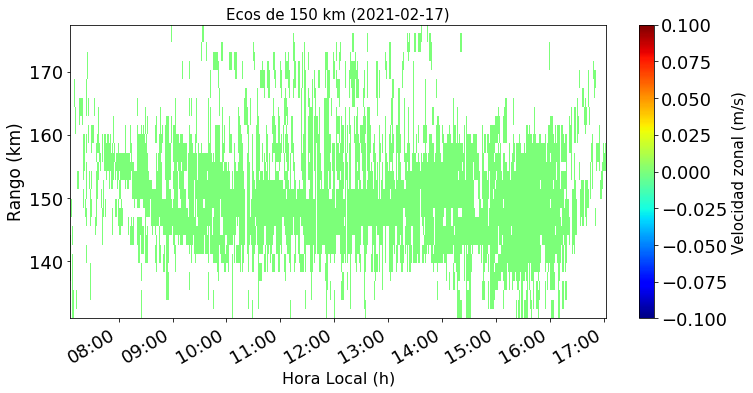

501
Vertical Average shape:  (501,) (501,) 2021-02-17 07:06:18 2021-02-17 17:02:22


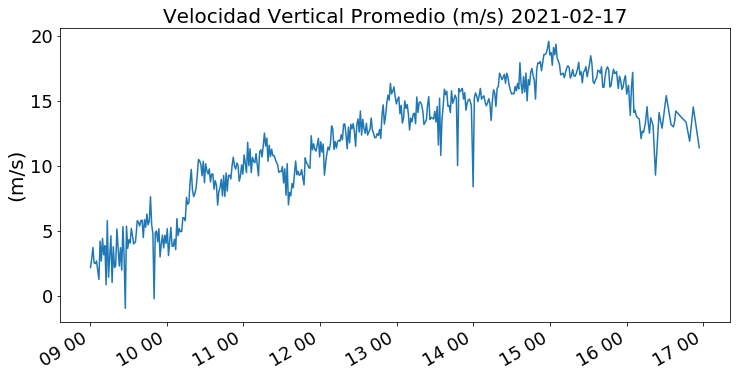

Range array shape:  (5699,)


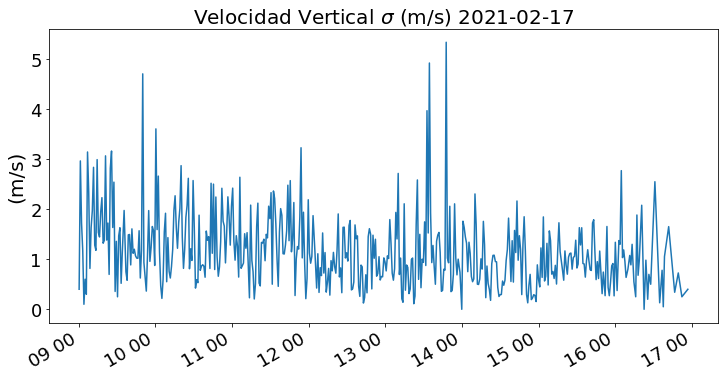

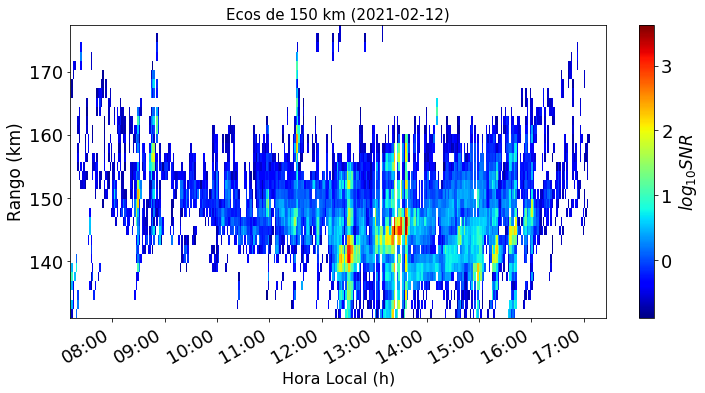

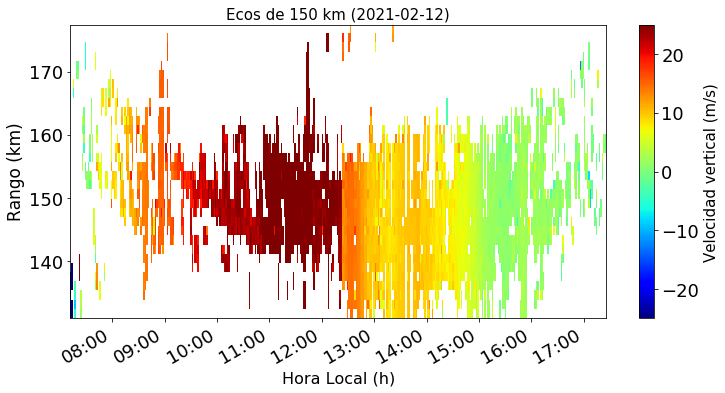

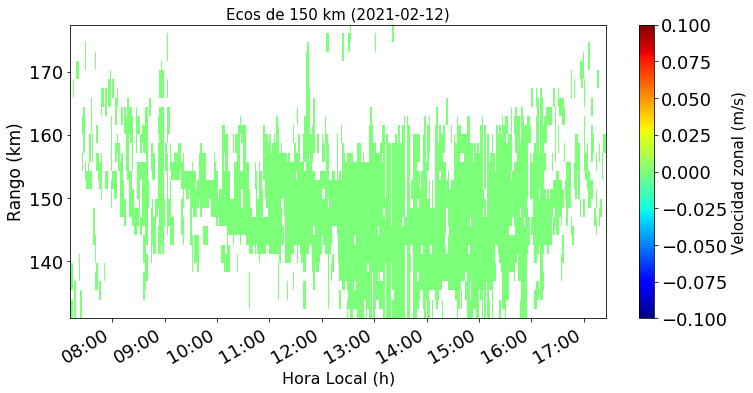

366
Vertical Average shape:  (366,) (366,) 2021-02-12 07:11:47 2021-02-12 17:25:40


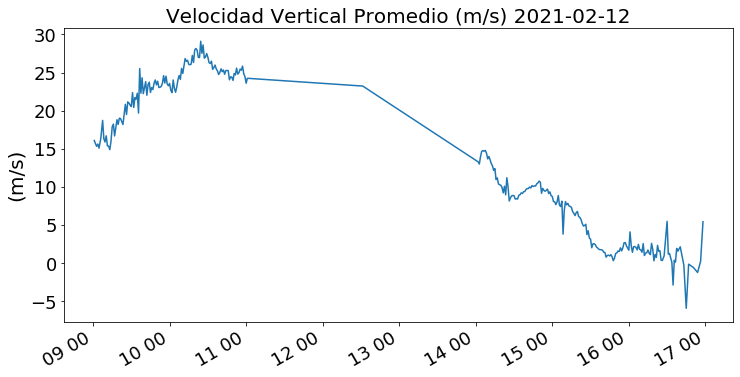

Range array shape:  (4046,)


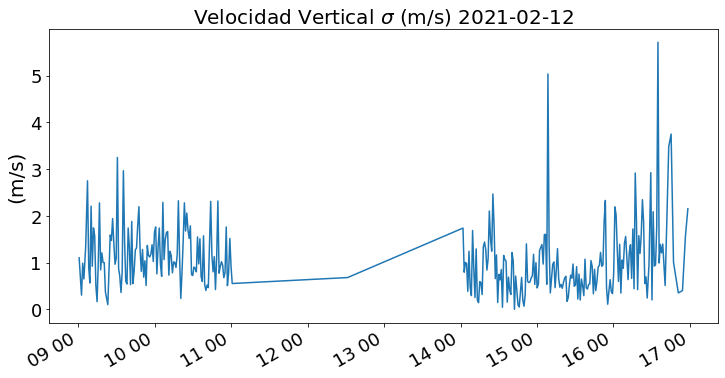

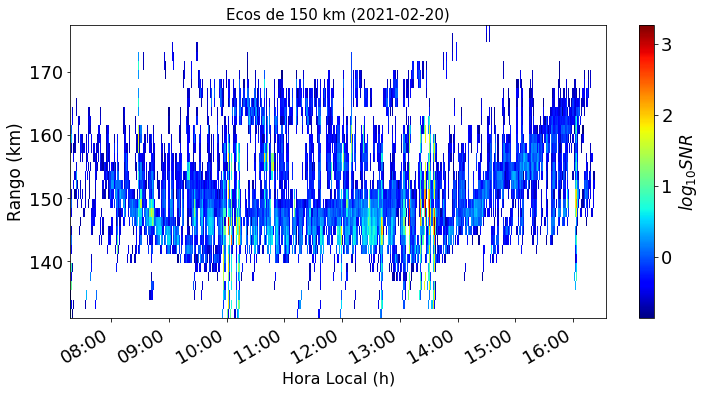

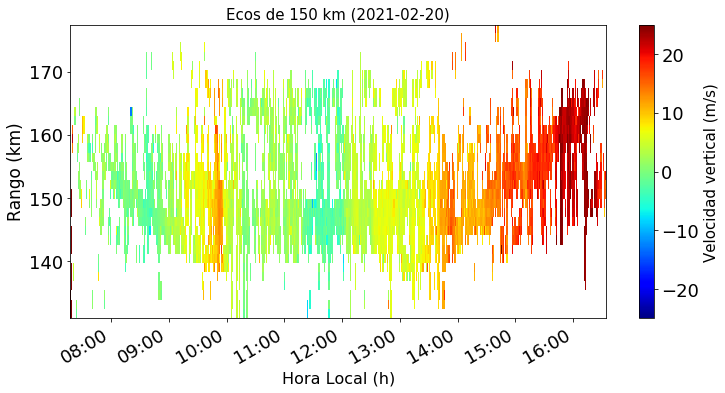

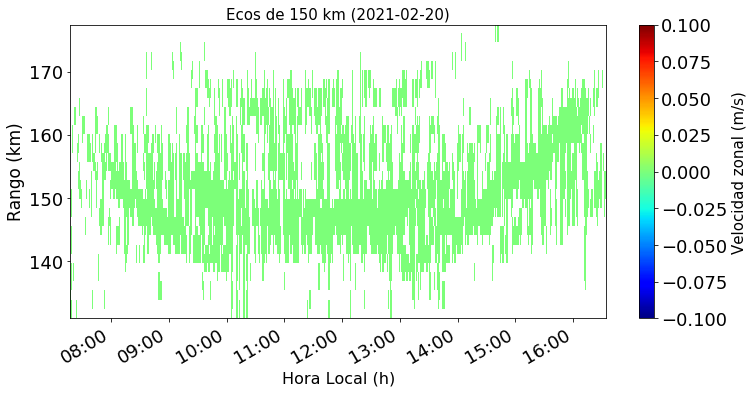

479
Vertical Average shape:  (479,) (479,) 2021-02-20 07:17:50 2021-02-20 16:34:00


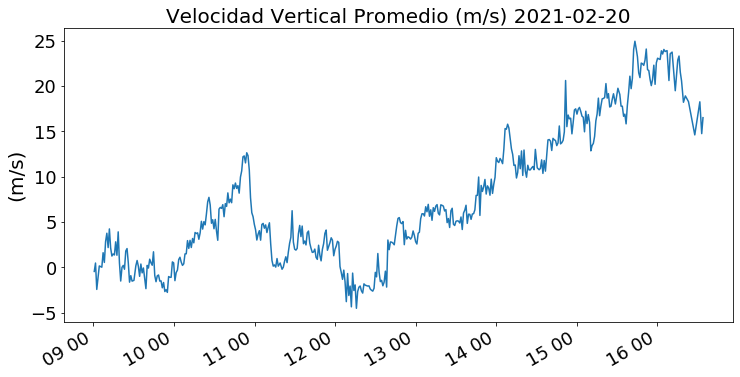

Range array shape:  (4839,)


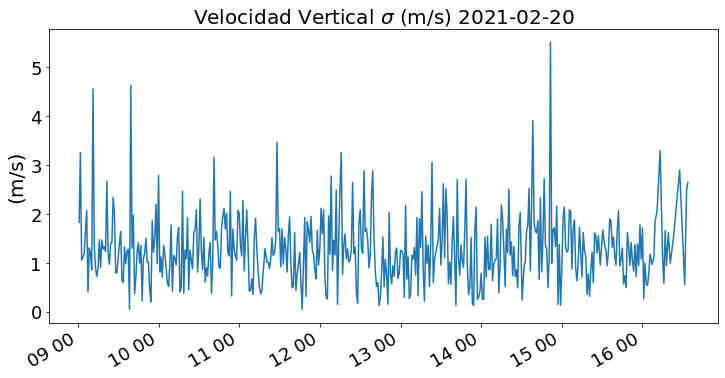

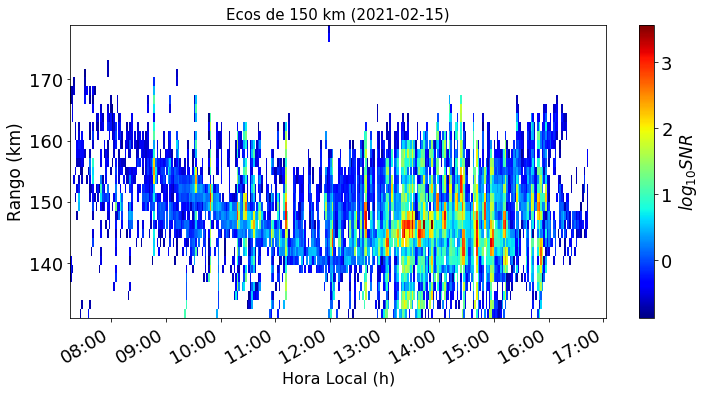

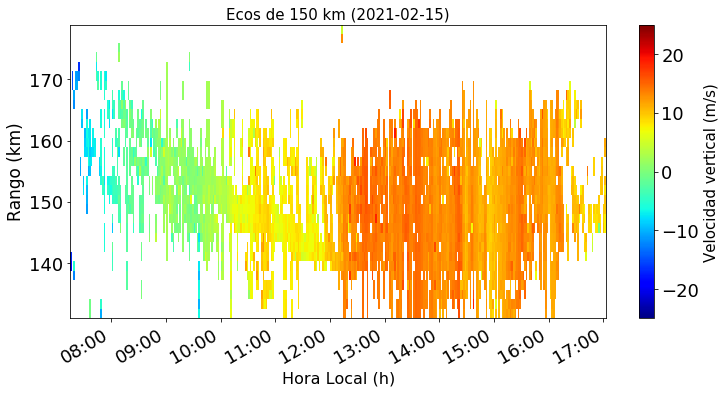

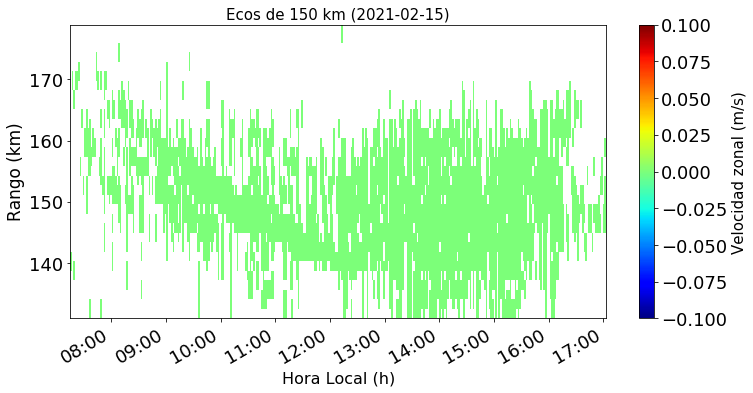

334
Vertical Average shape:  (334,) (334,) 2021-02-15 07:14:53 2021-02-15 17:03:00


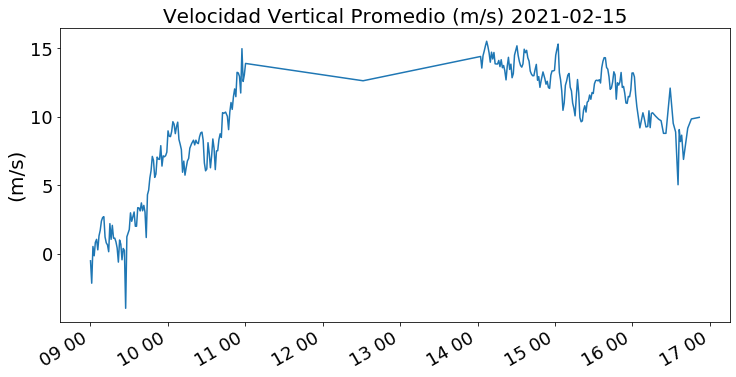

Range array shape:  (3906,)


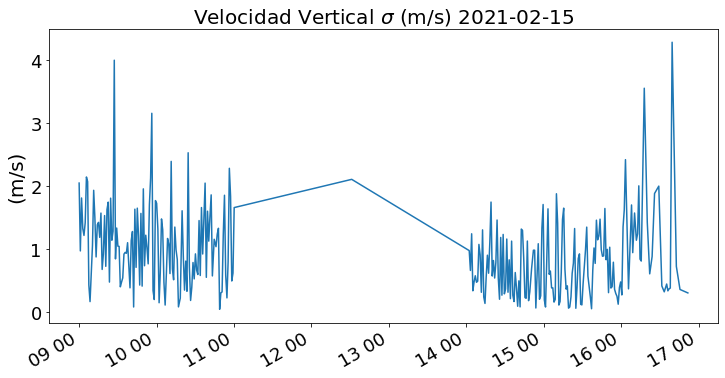

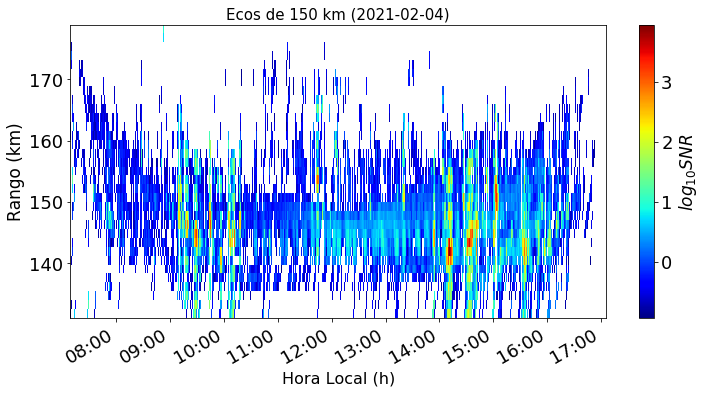

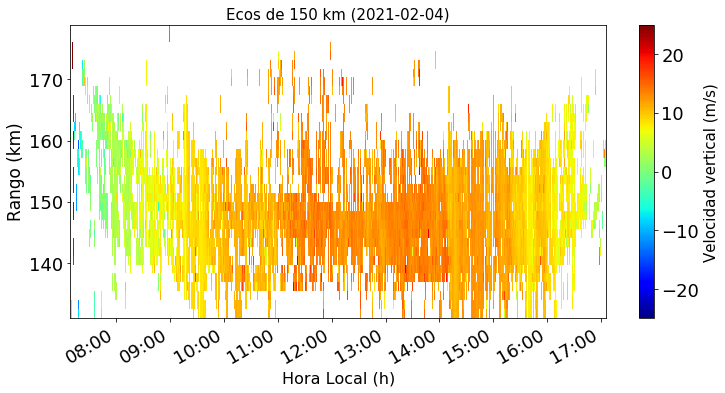

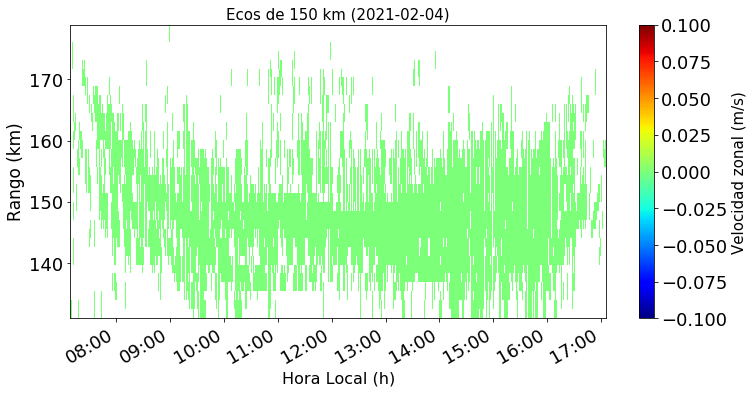

554
Vertical Average shape:  (554,) (554,) 2021-02-04 07:08:34 2021-02-04 17:05:34


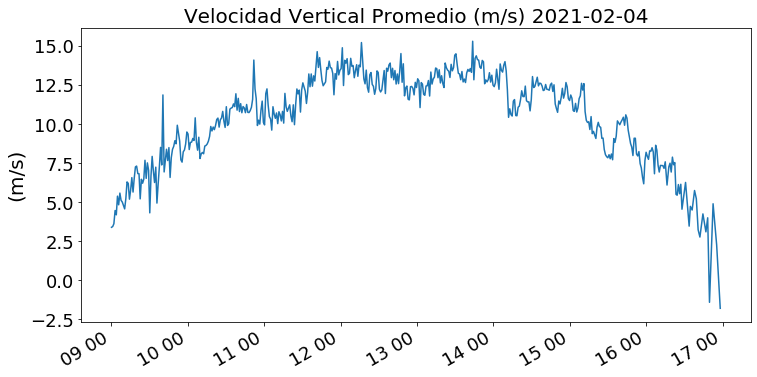

Range array shape:  (6998,)


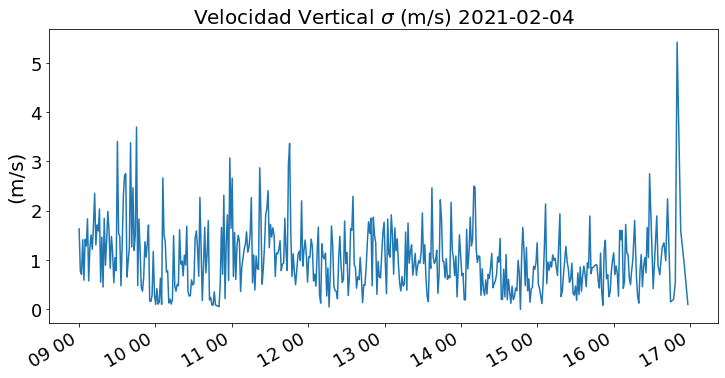

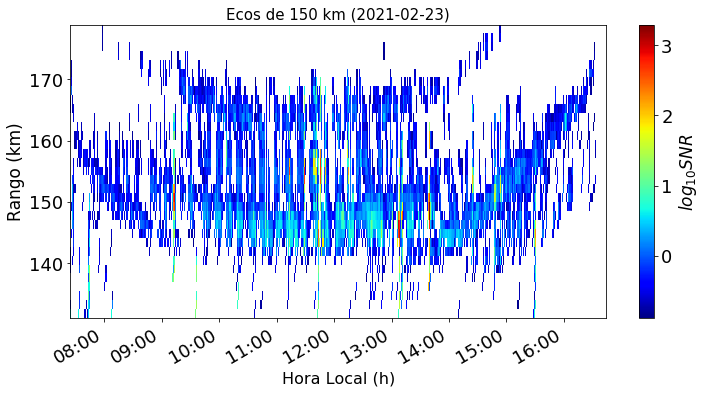

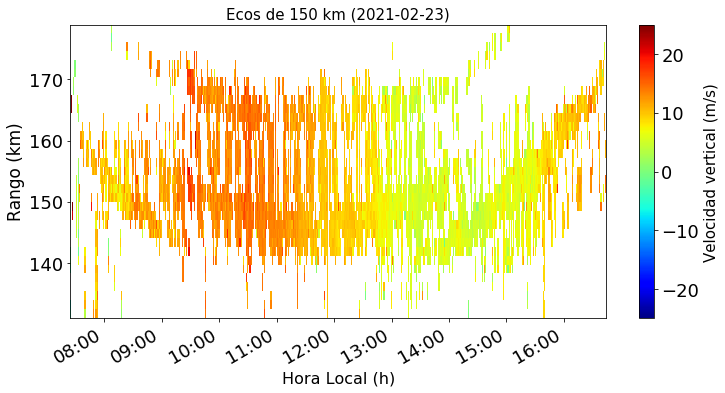

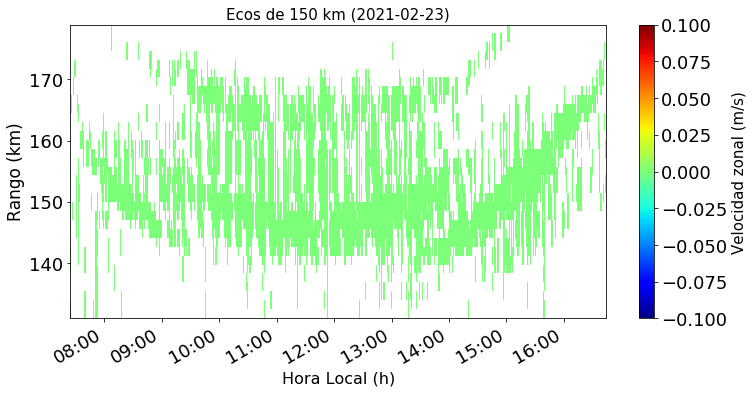

484
Vertical Average shape:  (484,) (484,) 2021-02-23 07:24:32 2021-02-23 16:43:59


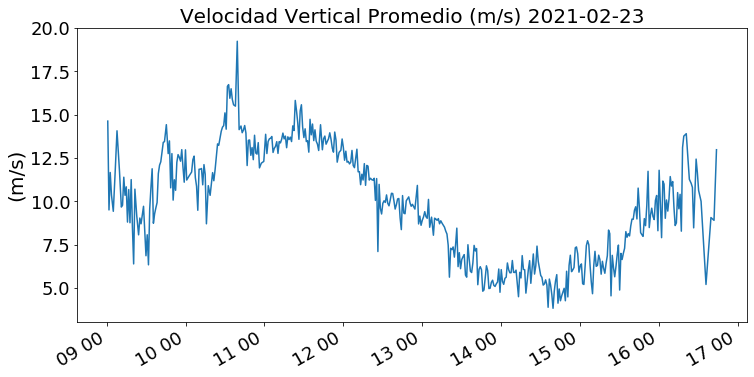

Range array shape:  (5038,)


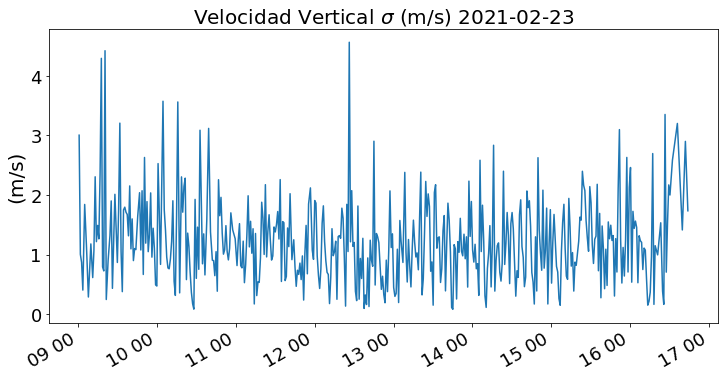

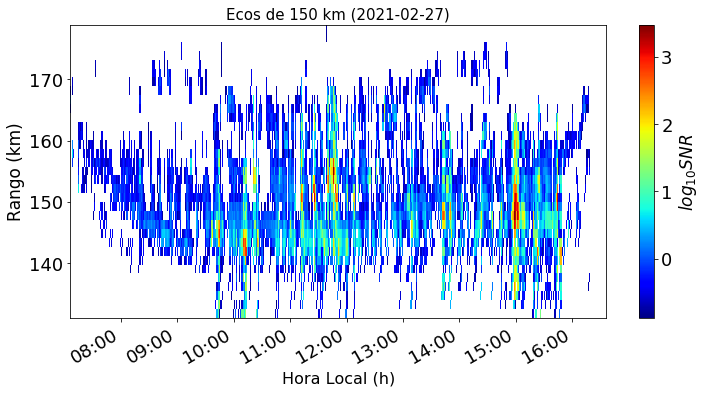

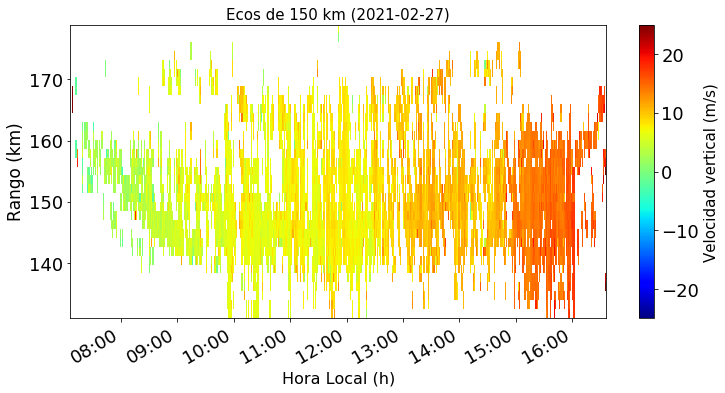

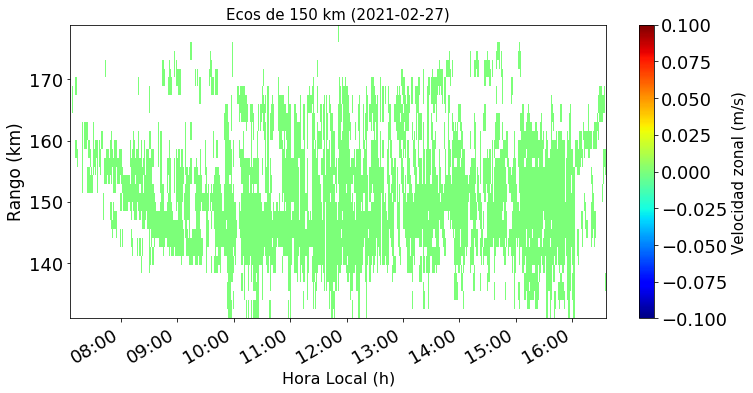

494
Vertical Average shape:  (494,) (494,) 2021-02-27 07:06:08 2021-02-27 16:35:55


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


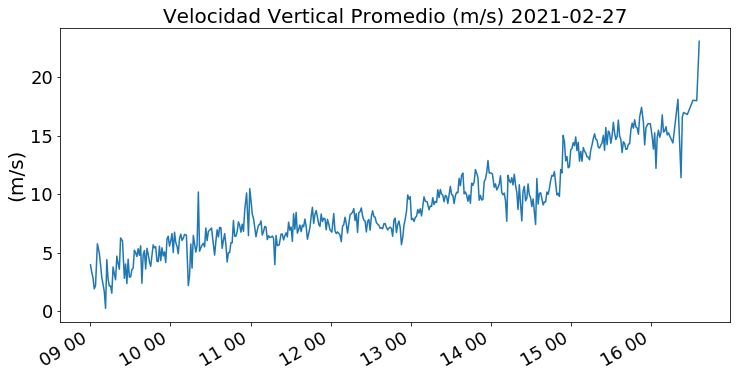

Range array shape:  (5656,)


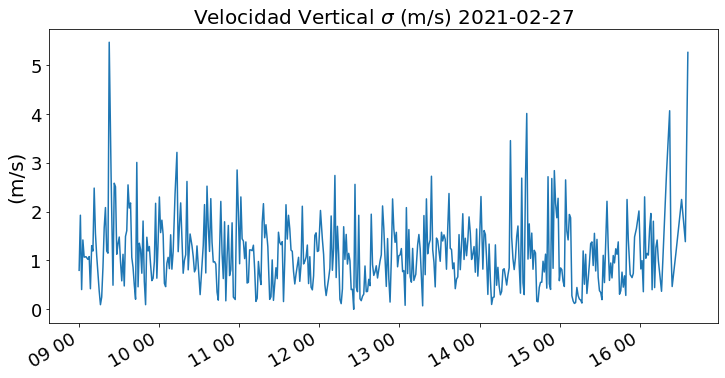

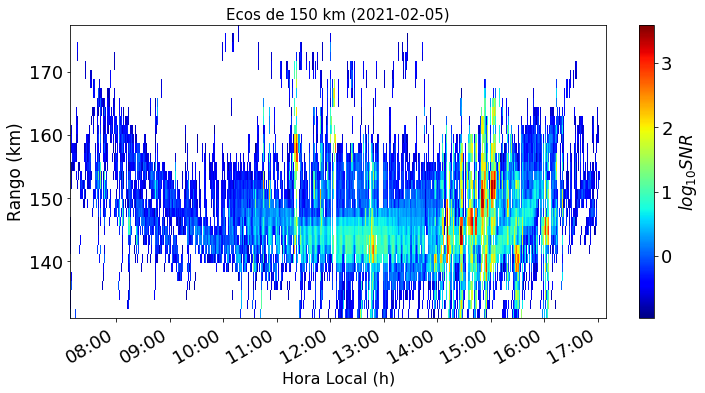

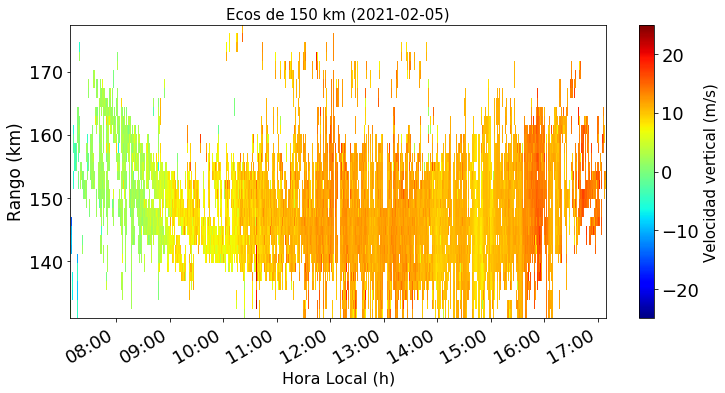

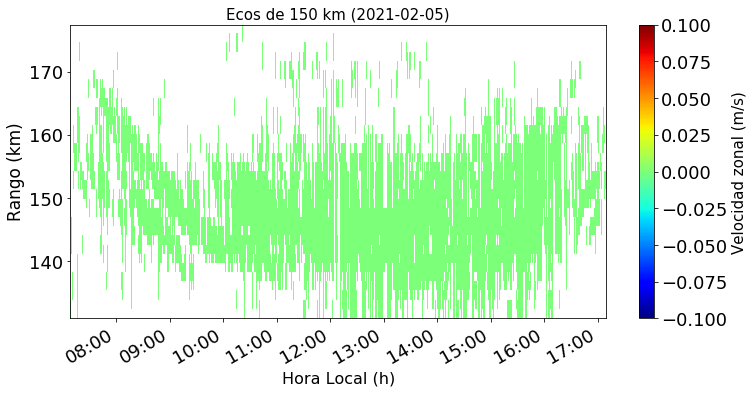

584
Vertical Average shape:  (584,) (584,) 2021-02-05 07:08:12 2021-02-05 17:09:24


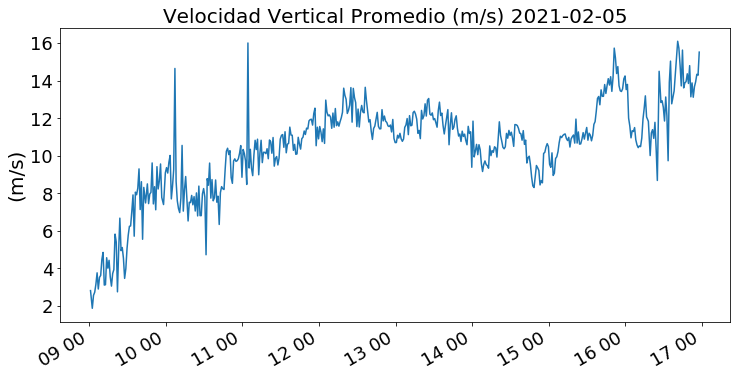

Range array shape:  (7297,)


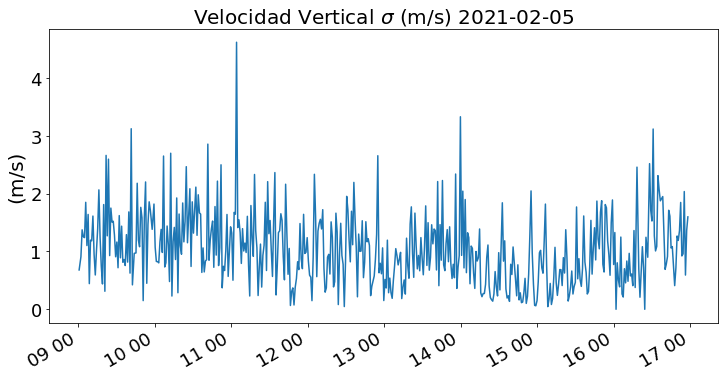

In [14]:
#'''
PlotFlag = True
plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = []
t_h_min = []
t_h_max = []
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        #print(os.path.join(directory, filename))
        data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2 = GetMatrix(directory, filename, PlotFlag, plot_format)
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango))
        prev_times = [' ']
        k = 0
        for time in index:
            if prev_times[k] == time:
                   print('Same Time')
            else:
                #print 'Different time'
                if not time in prev_times:
                    prev_times.append(time)
                prev_time = time

        h_min.append(min(rango))
        h_max.append(max(rango))
    ###########################################################
        ran_max = max(rango)
        ran_min = min(rango)
        #rang_list = list(rango)
        max_index = rango.index(ran_max)
        min_index = rango.index(ran_min)
        t_h_min.append(index[min_index].to_pydatetime())
        t_h_max.append(index[max_index].to_pydatetime())
    ############################################################
        num_stamps.append(len(timestamps))
        prev_times = prev_times[1:]
        num_diff_times = len(prev_times)
        print(num_diff_times)
        new_index = pd.DatetimeIndex(prev_times)
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        print("Vertical Average shape: ", v_vert_avg.shape, new_index.shape, new_index[0], new_index[-1])
        fig, ax = plt.subplots(figsize=(12, 6))
        str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        str_format = 'png'
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        #df_std = pd.Series(v_vert_std, index=new_index)
        df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
        string_t0 = '2021-%02d-%02d %02d:%02d:00' % (new_index[0].month, new_index[0].day, 9,0)
        string_tf = '2021-%02d-%02d %02d:00:00' % (new_index[0].month, new_index[0].day, 17)
        ax = df[string_t0:string_tf].plot()
        ax.set_ylabel('(m/s)', fontsize=20)
        ax.set_title('Velocidad Vertical Promedio (m/s) %s' % str_date, fontsize=20)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
        plt.savefig('velocidad-vertical-promedio-%s.%s' % (str_date, str_format))
        plt.show()
        plt.close(fig)
        print("Range array shape: ", np.array(rango).shape)
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        #str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        #str_format = 'png'
        #v_vert_avg = np.nanmean(v_vertical,axis=1)
        #v_vert_std = np.nanstd(v_vertical,axis=1)
        df_std = pd.Series(v_vert_std, index=new_index)
        #df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
        ax1 = df_std[string_t0:string_tf].plot()
        ax1.set_ylabel('(m/s)', fontsize=20)
        ax1.set_title(r'Velocidad Vertical $\sigma$ (m/s) %s' % str_date, fontsize=20)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
        plt.savefig('velocidad-vertical-desviacion-estandar-%s.%s' % (str_date, str_format))
        plt.show()
        plt.close(fig)
        frames_avg.append(df[string_t0:string_tf])
        frames_std.append(df_std[string_t0:string_tf])
#'''

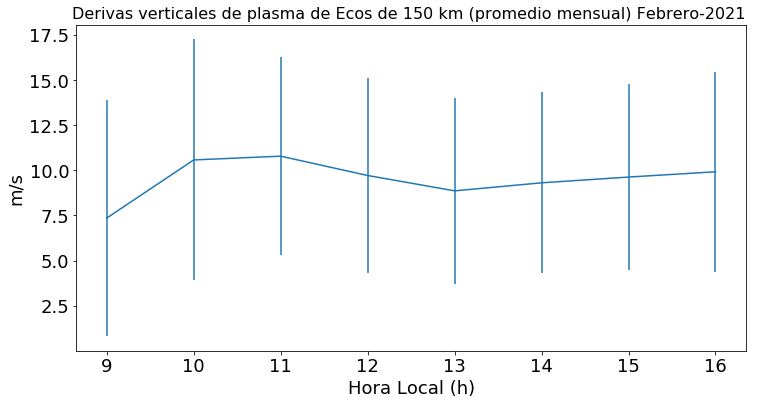

In [15]:
#'''
series_avg = pd.concat(frames_avg)
series_std = pd.concat(frames_std)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
series_avg.groupby(series_avg.index.hour).mean().plot(yerr=series_avg.groupby(series_std.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales de plasma de Ecos de 150 km (promedio mensual) %s ' % (current_month)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")
list_avg.append(series_avg.groupby(series_avg.index.hour).mean())
list_std.append(series_avg.groupby(series_std.index.hour).std())
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])

plt.savefig('promedio-mensual-drifts-%s.pdf' % current_month)
#'''

## Modelo de Scherliess-Fejer: Predicciones.

In [16]:
model_pred = []
if (year==2020):
    if (month==12):
        doys = [337,339,340,342,351,352,353,354,355,356,357,358,359,360,361,362]
        days = [2,4,5,6,8,19,20,21,22,23,24,25,26,27]
if (year==2021):
    if (month==2):
        days = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])
        doys = days + 31
        


In [ ]:
#year=2020
hour=10
longitude=-76.7
#month = 11
#year = 2020
#F107 = getF107(month,year)
#F107.tail(20)
#month = 11
#doy= 329
# = "2020-11-24 10:00:00" % (
modDrifts = []
xtimes = []
print(month)
for doy in doys:
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
#t = datetime.datetime.strptime(s, format)
#t = dt.timetuple()
#oy = tt.tm_yday
#f107cm = 80
    f107cm = getIndexF107(year, doy, hour)
    y,xt = drift_model(year,doy,longitude)
    df_v = pd.Series(y, index=xt)
    #mod_avg = np.nanmean(df_v)
    modDrifts.append(df_v)
    #mod_std = np.nanstd(v_vertical)
    #modDrifts_std.append(mod_std)    
    xtimes.append(xt)

2


In [ ]:
#'''
mod_series_avg = pd.concat(modDrifts)
#mod_series_std = pd.concat(modDrifts_std)
list_avg.append(mod_series_avg.groupby(mod_series_avg.index.hour).mean())
list_std.append(mod_series_avg.groupby(mod_series_avg.index.hour).std())
fig, axs = plt.subplots(figsize=(12, 6))
#plt.rcParams['ytick.labelsize']=16
#plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
mod_series_avg.groupby(mod_series_avg.index.hour).mean().plot(yerr=mod_series_avg.groupby(mod_series_avg.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales - Modelo de Scherliess-Fejer' 
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")
plt.xlim(9,16)
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local (h)', fontsize=18)
#axs.set_ylabel('m/s', fontsize=18)
#'''
plt.savefig('Scherliess-Fejer-%s.png' % current_month)

In [ ]:
fig3, ax3 = plt.subplots(figsize=(22,10))
exp = ['Ecos de 150 km', 'Modelo de Scherliess-Fejer']
markers = ['o', 'v']
plt.rcParams['ytick.labelsize']=20
plt.rcParams['xtick.labelsize']=20

for i in range(0,2):
    #for i in range(len(stations)):
    ax3 = list_avg[i].plot(yerr=list_std[i],label=exp[i], marker=markers[i])
    ax3.set_xlabel('Hora Local(h)', fontsize=25)
    ax3.set_ylabel(r'Derivas verticales (m/s) ', fontsize=25)
    ax3.set_title('Promedio mensual - Derivas verticales vs. modelo de Scherliess-Fejer', fontsize=25)
    #plt.plot(daily_averages, color=colors[i], label=stations[i])
    ax3.tick_params(axis='y', labelsize=24)
    ax3.tick_params(axis='x', labelsize=24)
    plt.xlim(9,16)
    plt.ylim(0,22)
    #plt.grid(True)
plt.legend(fontsize=23)    
print(current_month)
plt.savefig('ecos-150km-comparison-vdrifts-data-ISR-vs-Scherliess-Fejer-%s.png' % current_month)